## Seasonal Flu Vaccine Intake Classification - Project#3

* Student name: ***Aysu Erdemir***
* Student pace: ***Flex***
* Scheduled project review date/time: ***October, 2022***
* Instructor name: ***Abhineet Kulkarni***

## Overview

- **CDC wants to understand the leading factors in determining whether a person would take the sesoanal flu vaccine so that they could focus on the right strategies for their public efforts and vaccination campaigns to educate the public, raise awareness and maximize vaccine intake.**


- They also want to know the likelihood to receive the seasonal flu vaccine for specific demographic groups and have feedback about whether their efforts are successfull. 


- My goal is build a classifier to predict seasonal flu vaccination status using information they shared about their backgrounds, opinions, and health behaviors. My main purpose was to make predictions as accurately as possible.

## Business and Data Understanding
* The data was obtained from the **National 2009 H1N1 Flu Survey** provided at [DrivenData](https://www.drivendata.org/competitions/66/flu-shot-learning/). This phone survey asked people whether they had received H1N1 and seasonal flu vaccines, in conjunction with information they shared about their lives, opinions, and behaviors. 


* In this project I will be focusing on `seasonal flu` only and information regarding individuals' opinions about the H1N1 vaccine were excluded from the analyses. The relevant variables/features included in the dataset are:

**Target Feature**: 
* `seasonal_vaccine` - Whether respondent received seasonal flu vaccine or not.

**Predictive Features**:

* `behavioral_antiviral_meds` - Has taken antiviral medications. (binary)
* `behavioral_avoidance` - Has avoided close contact with others with flu-like symptoms. (binary)
* `behavioral_face_mask` - Has bought a face mask. (binary)
* `behavioral_wash_hands` - Has frequently washed hands or used hand sanitizer. (binary)
* `behavioral_large_gatherings` - Has reduced time at large gatherings. (binary)
* `behavioral_outside_home` - Has reduced contact with people outside of own household. (binary)
* `behavioral_touch_face` - Has avoided touching eyes, nose, or mouth. (binary)
* `doctor_recc_seasonal` - Seasonal flu vaccine was recommended by doctor. (binary)
* `chronic_med_condition` - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
* `child_under_6_months` - Has regular close contact with a child under the age of six months. (binary)
* `health_worker` - Is a healthcare worker. (binary)
* `health_insurance` - Has health insurance. (binary)
* `opinion_seas_vacc_effective` - Respondent's opinion about seasonal flu vaccine effectiveness. 1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.
* `opinion_seas_risk` - Respondent's opinion about risk of getting sick with seasonal flu without vaccine. 1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.
* `opinion_seas_sick_from_vacc` - Respondent's worry of getting sick from taking seasonal flu vaccine. 1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried. 
* `age_group` - Age group of respondent.
* `education` - Self-reported education level.
* `race` - Race of respondent.
* `sex` - Sex of respondent.
* `income_poverty` - Household annual income of respondent with respect to 2008 Census poverty thresholds.
* `marital_status` - Marital status of respondent.
* `rent_or_own` - Housing situation of respondent.
* `employment_status` - Employment status of respondent.
* `hhs_geo_region` - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
* `census_msa` - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
* `household_adults` - Number of other adults in household, top-coded to 3.
* `household_children` - Number of children in household, top-coded to 3.
* `employment_industry` - Type of industry respondent is employed in. Values are represented as short random character strings.
* `employment_occupation` - Type of occupation of respondent. Values are represented as short random character strings.


## Modeling

1. The dataset was cleaned and engineered.
2. The data was split into training and test sets.
3. The data was pre-processed. 
4. Several types of classifiers were built, tuned (using GridSearchCV to test combinations of hyperparameters) and validated:

    - Logistic Regression
    - Decision Tree
    - Random Forest
    - XGradient Boosted
    - Stacking Classifier (using above models)


## Evaluation

5. Roc_Auc was used as the scoring metric for tuning hyperparameters and evaluating model performance. 

    * The Roc_Auc metric utilizes **"probabilities"** of class prediction. Based on that, we’re able to more precisely evaluate and compare the models.
    * We also care equally about positive and negative classes, and the roc curve gives a desirable balance between **sensitivity/recall (maximizing True positive Rate)** and **specificity (minimizing False Positives).
    * Our focus is not just good predictions, but we want to delve deeper and understand feature importance and model characteristics. Because of this we will check out metrics on both train and test sets.


In [1]:
# Import required packages

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
import matplotlib.ticker as mticker

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.dummy import DummyClassifier


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix # plot_confusion_matrix is a visual tool added in the latest version of scikit-learn
from sklearn.metrics import confusion_matrix # if you are running an older version, use confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline # You need imblearn Pipeline for Smote work in a Pipeline

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Read the Data
data = pd.read_csv("./Data/FullDataSet.csv")
data.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [3]:
data.shape

(26707, 38)

In [4]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [5]:
data.respondent_id.duplicated().sum()
# No respondent ID has been coded twice

0

In [6]:
data.duplicated().sum()
# No data is dublicated

0

# Data Exploration and Data Cleaning:
## Columns to drop:

* `respondent_id` - redundant with index.
    
Since we are only interested in `seasonal_vaccine` as the target, let's drop the following columns specific to H1N1:

* `h1n1_vaccine`  - other target variable we are not addressing in this project
* `h1n1_concern`
* `h1n1_knowledge`
* `doctor_recc_h1n1`
* `opinion_h1n1_vacc_effective`
* `opinion_h1n1_sick_from_vacc`

In [7]:
data = data.drop(['respondent_id', 'h1n1_vaccine', 'h1n1_concern' ,'h1n1_knowledge' , 'doctor_recc_h1n1',
              'opinion_h1n1_vacc_effective' ,'opinion_h1n1_risk' ,'opinion_h1n1_sick_from_vacc'], axis = 1)     

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    26636 non-null  float64
 1   behavioral_avoidance         26499 non-null  float64
 2   behavioral_face_mask         26688 non-null  float64
 3   behavioral_wash_hands        26665 non-null  float64
 4   behavioral_large_gatherings  26620 non-null  float64
 5   behavioral_outside_home      26625 non-null  float64
 6   behavioral_touch_face        26579 non-null  float64
 7   doctor_recc_seasonal         24547 non-null  float64
 8   chronic_med_condition        25736 non-null  float64
 9   child_under_6_months         25887 non-null  float64
 10  health_worker                25903 non-null  float64
 11  health_insurance             14433 non-null  float64
 12  opinion_seas_vacc_effective  26245 non-null  float64
 13  opinion_seas_ris

In [9]:
data.describe()
# Many of the numerical variables appear as ordinal in nature. 

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,seasonal_vaccine
count,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000
mean,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.329735,0.283261,0.082590,0.111918,0.87972,4.025986,2.719162,2.118112,0.886499,0.534583,0.465608
std,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.470126,0.450591,0.275266,0.315271,0.32530,1.086565,1.385055,1.332950,0.753422,0.928173,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000


## Check for null values:

In [10]:
data.isnull().sum()
# There are many null values

behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
hhs_geo_region                     0
census_msa                         0
household_adults                 249
household_children               249
e

In [11]:
# Proportion of null values for the variables:
nulls = ((data.isnull().sum()*100) / len(data)).sort_values(ascending=False)
nulls[nulls > 0]

employment_occupation          50.436215
employment_industry            49.912008
health_insurance               45.957989
income_poverty                 16.561201
doctor_recc_seasonal            8.087767
rent_or_own                     7.645936
employment_status               5.477965
marital_status                  5.272026
education                       5.268282
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
opinion_seas_sick_from_vacc     2.010709
opinion_seas_risk               1.924589
opinion_seas_vacc_effective     1.729884
household_children              0.932340
household_adults                0.932340
behavioral_avoidance            0.778822
behavioral_touch_face           0.479275
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_antiviral_meds       0.265848
behavioral_wash_hands           0.157262
behavioral_face_mask            0.071142
dtype: float64

* `employment_occupation`, `employment_industry`, `health_insurance` and `income_poverty` columns contain the most missing values, with null values making up **50.4%, 49.9%, 45.9%, 16.5%** of the data, respectively.

In [12]:
print(data.employment_occupation.value_counts().head())
print(data.employment_industry.value_counts().head())

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
Name: employment_occupation, dtype: int64
fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
Name: employment_industry, dtype: int64


### Drop `employment_occupation` and `employment_industry`:

* For `employmeny_industry` and `employment_occupation` the data is encripted, the codes are random strings, meaning we would not be able to make any specific recommendations based on occupation or industry. Given also half of the data is missing for these variables let's drop these variables. 

In [13]:
data = data.drop(['employment_occupation','employment_industry'], axis=1)

### Display missing values: 

* **Missingno** library offers a very nice way to visualize the distribution of Null values.

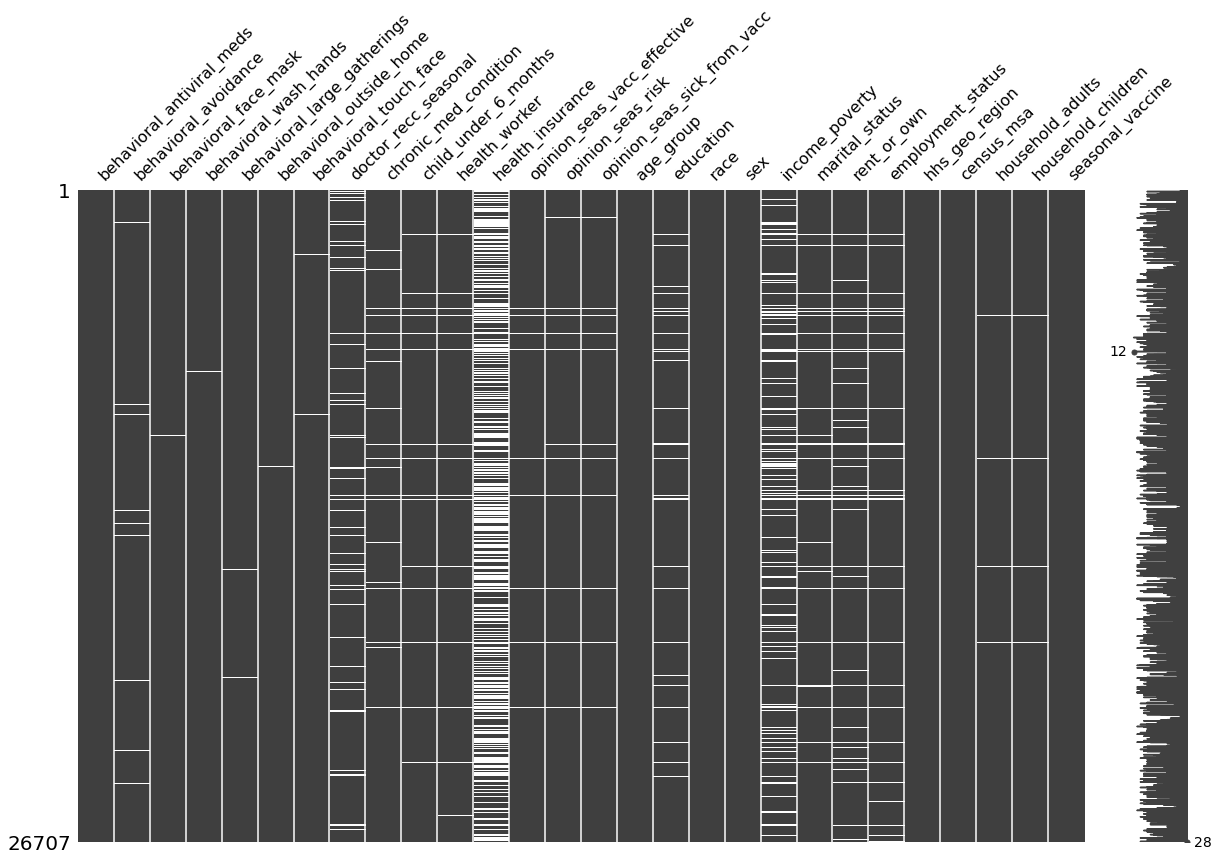

In [14]:
# Display null values across all rows/columns to check for specific patterns for the absence of data:
import missingno
missingno.matrix(data, figsize=(20, 12));

In [15]:
# Display the rows with at least 9 missing data points across 29 variables. 
data[(data.isnull().sum(axis=1) >= 9)]

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,seasonal_vaccine
64,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,...,Female,NaN,NaN,NaN,NaN,kbazzjca,Non-MSA,1.0,2.0,0
175,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,...,Female,NaN,NaN,NaN,NaN,mlyzmhmf,"MSA, Principle City",1.0,0.0,1
183,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,...,Female,NaN,NaN,NaN,NaN,lrircsnp,"MSA, Principle City",NaN,NaN,0
203,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,...,Female,NaN,NaN,NaN,NaN,lrircsnp,Non-MSA,0.0,0.0,1
205,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,...,Female,NaN,NaN,NaN,NaN,bhuqouqj,"MSA, Principle City",NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26510,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,Male,NaN,NaN,NaN,NaN,qufhixun,"MSA, Principle City",0.0,0.0,1
26526,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,Female,NaN,NaN,NaN,NaN,fpwskwrf,Non-MSA,NaN,NaN,0
26549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,Female,NaN,NaN,NaN,NaN,oxchjgsf,Non-MSA,1.0,2.0,1
26608,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,...,Female,NaN,NaN,NaN,NaN,lrircsnp,"MSA, Not Principle City",0.0,0.0,0


### Drop rows/participants with at least 10 missing data:

* The Matrix above shows a pattern indicating 761 have not given an answer for at least 9 out of the 29 questions, which are related to their opinions on vaccine risks and demographic backgrounds.  
* This might make their data unreliable with at least 1/3rd of the variables missing, so let's drop those participants data from the full dataset. 

In [16]:
data_clean = data.drop(data[(data.isnull().sum(axis=1) >= 9)].index, axis=0)
data_clean.shape

(25946, 28)

In [17]:
nulls = ((data_clean.isnull().sum()*100) / len(data)).sort_values(ascending=False)
nulls[nulls > 0]

health_insurance               43.112293
income_poverty                 13.715505
doctor_recc_seasonal            7.391321
rent_or_own                     4.800240
employment_status               2.632269
marital_status                  2.430075
education                       2.430075
chronic_med_condition           0.917362
behavioral_avoidance            0.733890
behavioral_touch_face           0.449320
behavioral_large_gatherings     0.299547
behavioral_outside_home         0.295803
behavioral_antiviral_meds       0.250871
child_under_6_months            0.239638
health_worker                   0.209683
opinion_seas_vacc_effective     0.164751
opinion_seas_risk               0.131052
behavioral_wash_hands           0.131052
household_children              0.086120
household_adults                0.086120
behavioral_face_mask            0.063654
opinion_seas_sick_from_vacc     0.041188
dtype: float64

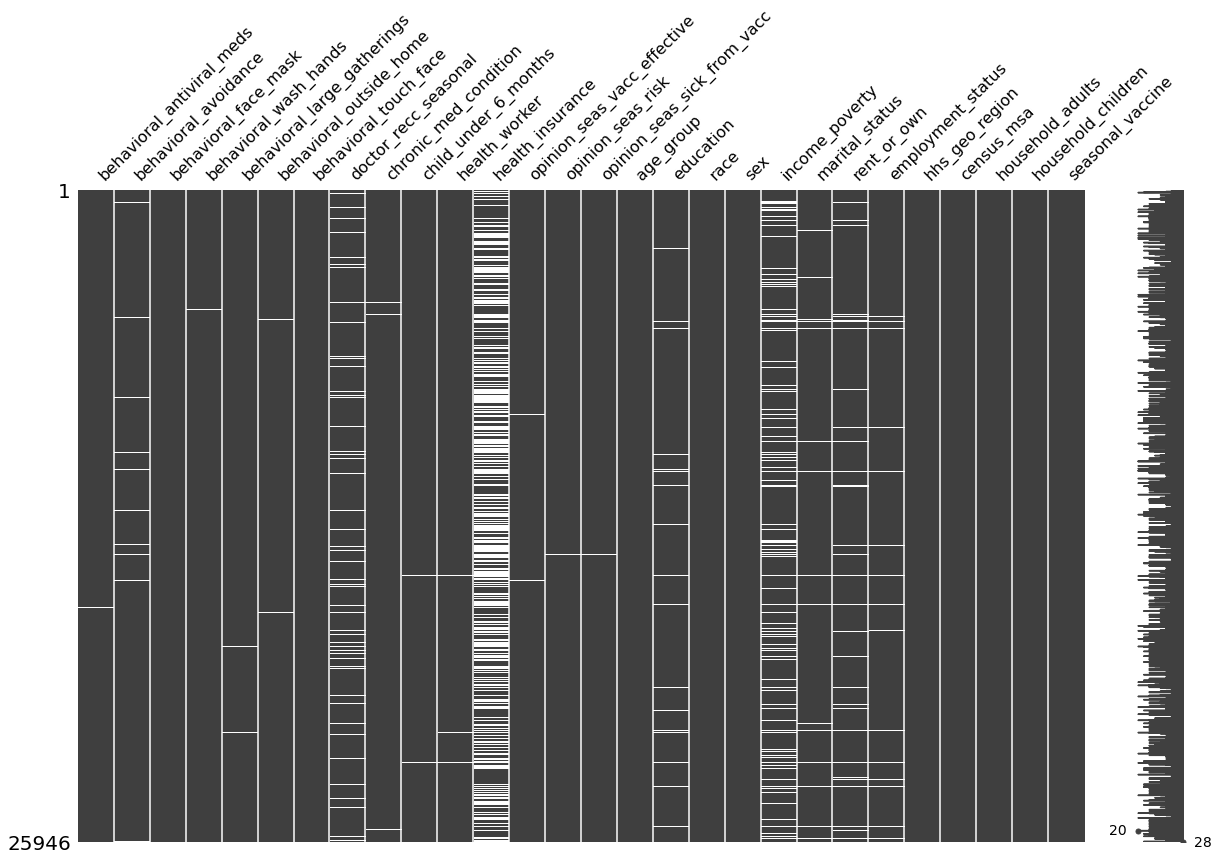

In [18]:
missingno.matrix(data_clean, figsize=(20, 12));
# Looks much better now:

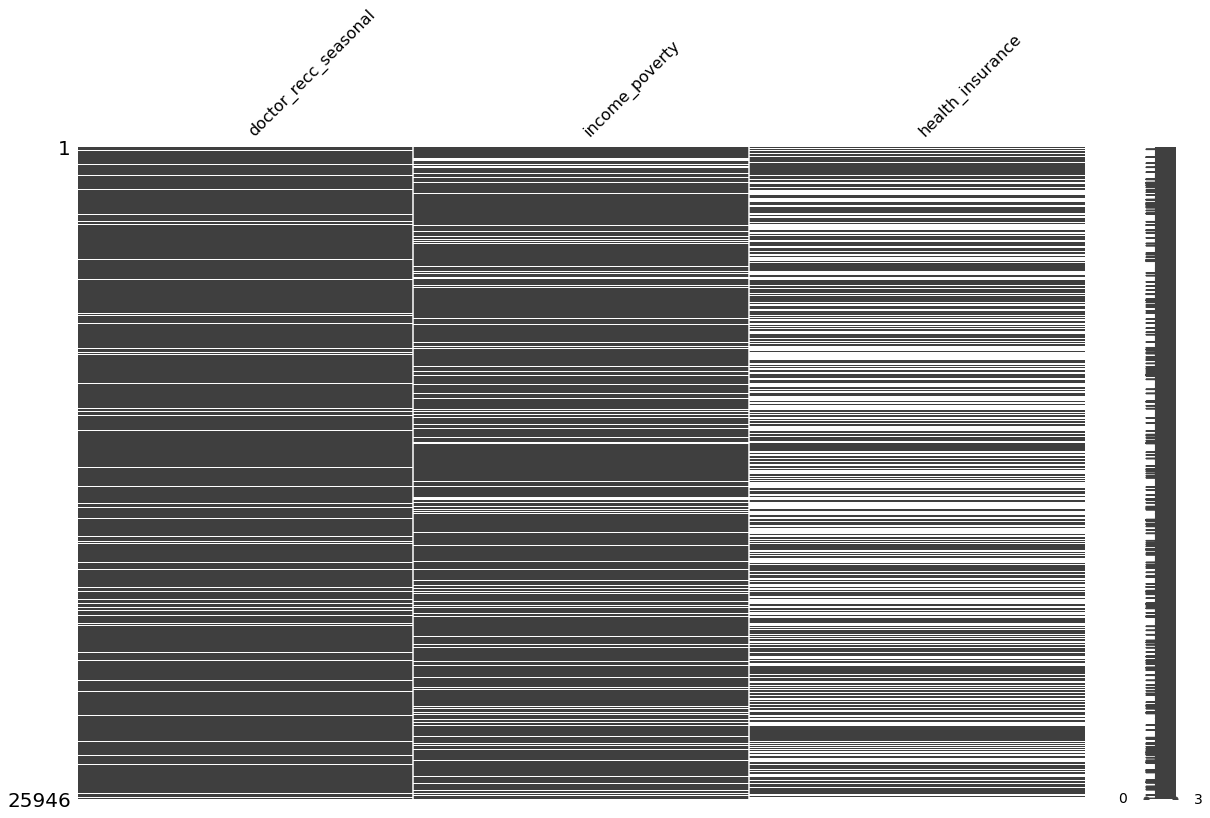

In [19]:
missingno.matrix(data_clean[['doctor_recc_seasonal','income_poverty', 'health_insurance']],  figsize=(20, 12));

###  `health_insurance`,  `income_poverty`,  `doctor_recc_seasonal`:

* `health_insurance` has 43% null values, but it might be an important feature for predicting vaccine intake.
* `income_poverty` has 13% null values, and it might also be an important feature for predicting vaccine intake.
* `doctor_recc_seasonal` has 7% null values, and it might also be an important feature for predicting vaccine intake.

Let's see if there are some trends in the data for us to be able to impute a meaningful value in place of the null values for these variables.

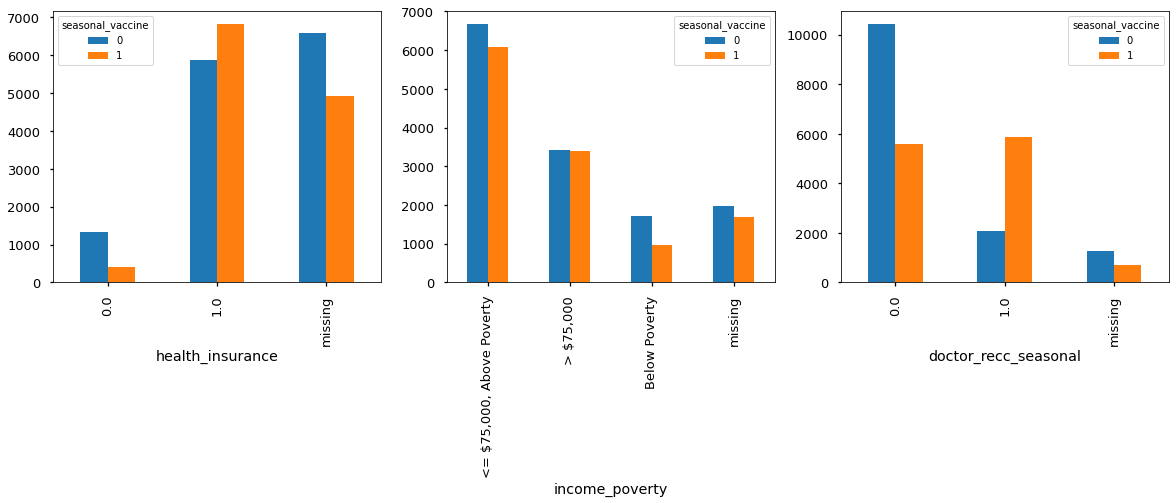

In [20]:
# Create a copy of the data frame and rename the null values as 'missing' 
# to be able to visualize the distribution of 1, 0 and null values in relation to vaccine intake

data_temp = data_clean.copy()
vrbls = ['health_insurance', 'income_poverty', 'doctor_recc_seasonal']

with plt.style.context('seaborn-talk'):
    fig, ax_list = plt.subplots(ncols = 3, figsize=(20,5))  
    
for i in [0,1,2]:
    data_temp[vrbls[i]] = data_temp[vrbls[i]].fillna('missing')
    counts = data_temp[['seasonal_vaccine',vrbls[i]]].groupby(['seasonal_vaccine',vrbls[i]]).size().unstack('seasonal_vaccine')
    counts.plot.bar(ax=ax_list[i])
        

`health_insurance`:
* Majority of those people WITHOUT a health insurance did NOT take the vaccine.
* Majority of those people WITH a health insurance took the vaccine.
* Majority of those people who have not provided info about health insurance also did NOT take the vaccine.
* **Although it is more likely for a person who did not provide info on insurance to not to take the vaccine, we cannot reliably conclude whether they had insurance or not, since the majority of the people indeed had insurance regardless of taking the vaccine.** 
* We cannot predict the null values reliably using a single value. 

`income_poverty`:
* The trend for the those people who have not provided info on income does not entail a specific class strongly. We cannot predict the null values reliably using a single class value. 

`doctor_recc_Seasonal`:
* The trend for those people who have not provided info on doctor_recc_seasonal fits to those who responded 0, which is also majotiy. 
* Since the null values only make 7% of the full dataset, it makes sense to replace the null values with the **most frequent** value in this case. 

### Are those people who did not give an answer for health insurance mostly below poverty level?

* Only %26 of the people who did not give an answer for `health_insurance` are either did not give an answer for `income_poverty` or are at below poverty level. 

In [21]:
len(data_clean[ (data_clean.health_insurance.isnull()) & 
       ( (data_clean.income_poverty.isnull()) | (data_clean.income_poverty == 'Below Poverty'))
      ])\
/len(data_clean[data_clean.health_insurance.isnull()])

0.2635921486885531

### Does `health_insurance` correlate with any other variable strongly?

* `health_insurance` correlates highest with `doctor_recc_seasonal` which could be expected, but the correlation coefficient is still .17 which is weak. None of the variables appear as a strong predictor of `health insurance`. 


In [22]:
# Create a new df with cat codes - numbers - (temporarily) to see the distibution and correlation of variables.
data_cat = data
data_cat = data_cat.apply(lambda x: x.astype('category').cat.codes)

In [23]:
corr_insurance = data_cat.corr().abs()['health_insurance']
corr_insurance.sort_values(ascending=False).head()

health_insurance        1.000000
doctor_recc_seasonal    0.177899
marital_status          0.116988
education               0.112787
employment_status       0.111562
Name: health_insurance, dtype: float64

* It could be argued that the best practice is to drop `health_insurance` column entirely since it contained 43% null values. However `health_insurance` is expected to be a significant factor in our classification so we will keep it. 

* Another option would be to convert both `health insurance` and `income_poverty` to an object type and replace the null values with a new constant value such as 'missing', in such case, this class would be treated as a separate category after One-Hot Encoding.

* However instead, in an aim to increase the likelihood of accuracy of predictions I will run a **predictive model** that imputes the missing values and plug those predictions in to be used in my final model that predicts vaccine status.

* I would argue that using predictions from a predictive model for the null values, would be at least "more accurate" than replacing them with some value at random or than treating them as a separate category. 

### Multicollinearity:

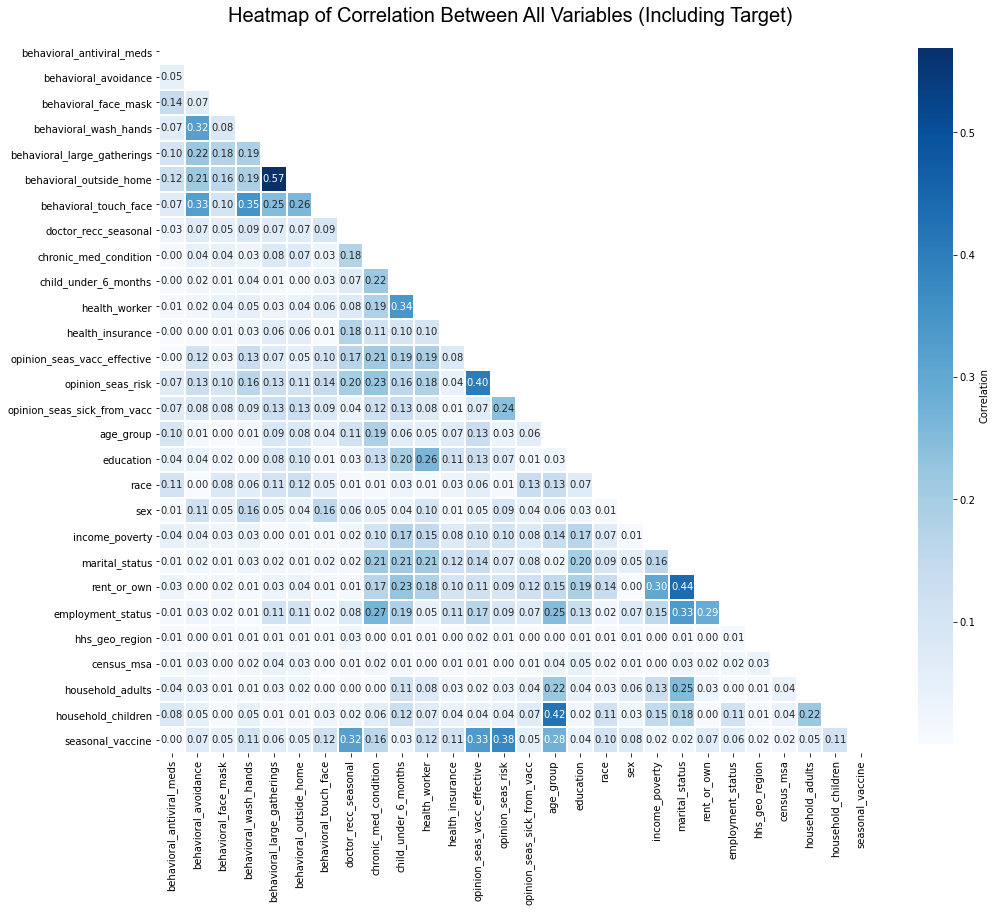

In [24]:
# Heat Map showing the correlation between all variables including the target
corr = data_cat.corr().abs()

fig, ax=plt.subplots(figsize=(16,16))
matrix = np.triu(corr) # Getting the Upper Triangle of the correlation matrix
cbar_kws={"label": "Correlation", "shrink":0.8}
heatmap = sns.heatmap(data = corr, cmap='Blues', linewidths = 1, square= True,  ax=ax, annot=True, mask=matrix, fmt= ".2f", cbar_kws=cbar_kws) 
fig.suptitle('Heatmap of Correlation Between All Variables (Including Target)', fontsize=20, y=.84, x = .43, fontname='Arial');
heatmap;

### Heat map summary:
* Multicollinearity is not a big concern for classifications in general but if there are some variables that stand out with very high correlation (e.g. higher than .7) we might choose to remove those variables: 
* Based on heatmap below no correlation is higher than .7, so we will keep them all.

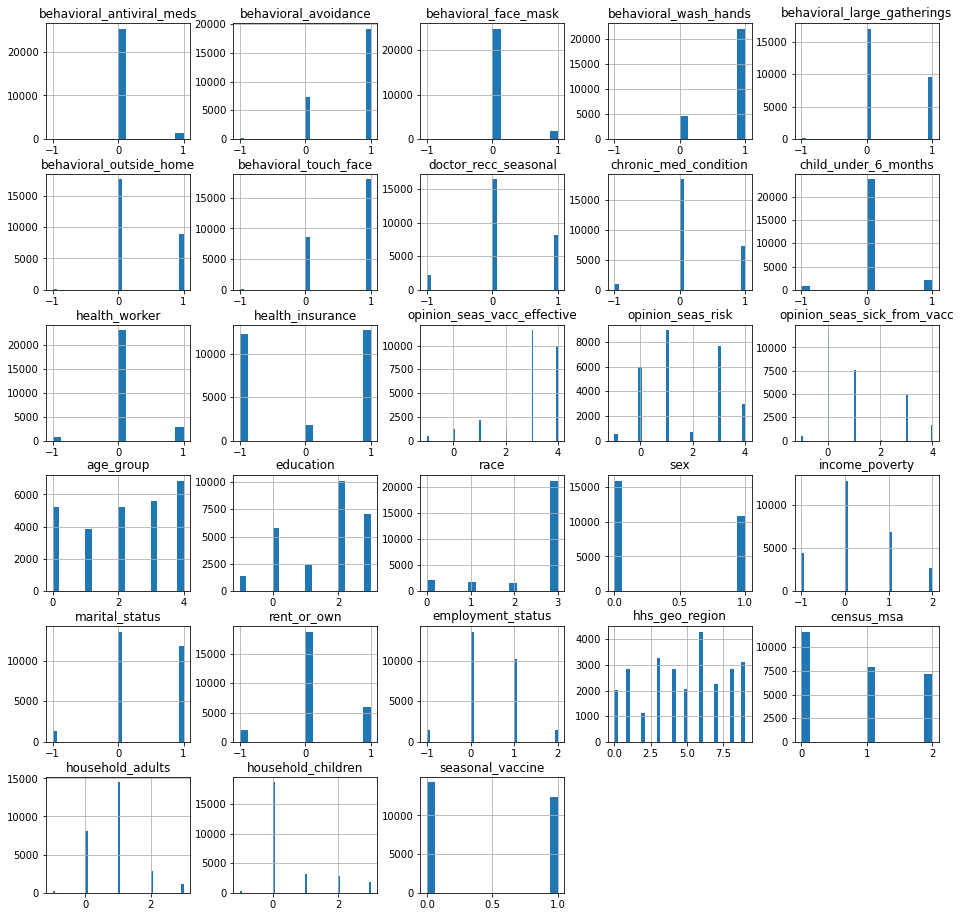

In [25]:
# Check out the distribution of all variables
data_cat.hist(bins='auto', edgecolor='none', figsize=(16,16));
# -1 represents null values in the histogram

### Histogram summary:
* There are binary (yes/no) variables, numerical variables (ordinal in nature) and categorical variables (nominal) in the data set. Depending on the nature of the variable, we will use a different strategy for filling in the null values. 

## How will the null values be handled?

* All variables appear as **categorical** in nature (possibly because the data was a survey data).

### Binary Columns:
* Many of variables in float type are actually **binary (yes/no)**. 
* Given that the proportion of null values are not too high for these variables, the null values will be replaced with the **most frequent**. 

    #### `health_insurance`:
    * This variable will be treated as **binary (yes/no)**.
    * A **predictive model** will be used to impute the missing values and then these values will be merged into the dataset. 

### Numerical Columns:
* Some of variables in float type are **ordinal** (some sense of ordering to its categories), so they will be treated as **numerical**. 
* The null values will be replaced with the **Median**. 

### Categorical Columns:
* The variables in object type are **nominal** (no intrinsic ordering to its categories), so they will be treated as **categorical**. 
* The null values will be replaced with a **contant('missing')** creating its own level before one-hot encoding these variables. 

    #### `income_poverty`:
    * This variable will be treated as **categorical**.
    * A **predictive model** will be used to impute the missing values and then these values will be merged into the dataset. 


### Are the variables `health_insurance`, `income_poverty` balanced or inbalanced? 
* Based on below graph it appears as though these variables have **imbalanced** classes. 

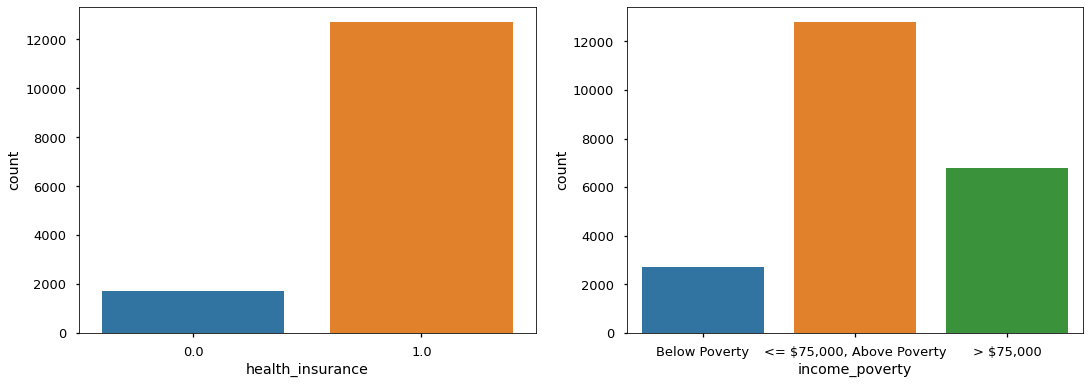

In [26]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols =2, figsize=(18, 6))
    sns.countplot(data_clean['health_insurance'], ax= ax1);
    sns.countplot(data_clean['income_poverty'], ax= ax2);

### Is the main target variable `seasonal_vaccine` balanced or imbalanced? 
* Based on below graph it appears as though the seasonal flu vaccine target has **balanced** classes. 

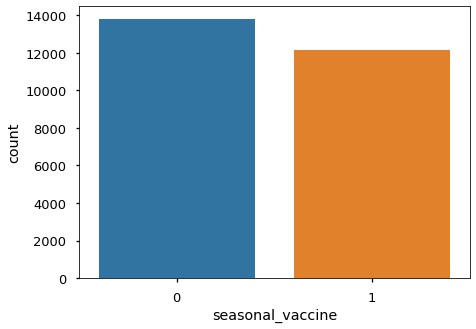

In [27]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.countplot(data_clean['seasonal_vaccine'], ax= ax);

# FEATURE ENGINEERING:

### Null replacement for `health_insurance` using predictive modeling:

* We will create a new subset of the full dataset called **df_insurance_train** with all the rows with null values for `health_insurance` being dropped.
* We will Set aside another dataset called **df_insurance_test** containing only the null values for `health_insurance`. The final model will be used to predict the null values in this dataset.  
* We will test-train split **df_insurance_train**. Using a RandomForest approach Tune, Train, Test the model.
* We will use the final model to impute predictions for **df_insurance_test** which was set aside.
* We will combine the two datasets to come up with a full dataset again, with null values for `health_insurance` being imputed with predictions.

In [28]:
data_clean = data_clean.copy()

In [29]:
# Create a new subset of the dataframe with null values dropped. The new df has 14432 data points. 
df_insurance_train = data_clean.dropna(subset = ['health_insurance'], axis=0)
df_insurance_train.shape

(14432, 28)

In [30]:
# Create a new subset of the dataframe with only null values. 
# We will use our model to predict the null values in this dataset. 
df_insurance_test = data_clean[data_clean['health_insurance'].isnull()].drop('health_insurance', axis=1)
df_insurance_test.shape

(11514, 27)

In [31]:
# Fatures to be used for predicting health_insurance:
binary_columns = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 
                  'behavioral_wash_hands','behavioral_large_gatherings', 'behavioral_outside_home',
                  'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 
                  'child_under_6_months', 'health_worker', 'seasonal_vaccine']

num_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                'opinion_seas_sick_from_vacc','household_adults','household_children']

cat_columns = ['age_group', 'education', 'race', 'sex','income_poverty', 'marital_status', 
               'rent_or_own', 'employment_status','hhs_geo_region', 'census_msa']

### Specify X and y:

In [32]:
X = df_insurance_train.drop('health_insurance', axis=1)
y = df_insurance_train['health_insurance']

### Test-Train split the data:
- You should always split the data before applying any scaling/preprocessing techniques in order to avoid data leakage

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42)

X_train_binary = X_train[binary_columns]
X_train_nums = X_train[num_columns]
X_train_cats = X_train[cat_columns]

In [34]:
assert ((len(X_train_nums.columns) + len(X_train_cats.columns) + len(X_train_binary.columns)) == len(X.columns))

## Preprocessing Steps:

- **NA imputation** for ***binary, numerical and categorical*** variables
    * For the binary/numerical variables, impute with the ***most frequent***.
    * For the ordinal/numerical variables, impute with the ***median***.
    * For the categorical variables, impute with a constant: the string ***'missing'***. 
- **One-Hot-Encoding** for the ***categorical variables*** only. 
- **Scaling** for the ***numerical variables*** only (since binary and categorical variables are already encoded as 0 and 1). 

In [35]:
binary_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='most_frequent'))
])

numerical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

# grab columns out of a pandas data frame and then apply a specified transformer.
preprocessor = ColumnTransformer(transformers=[
    ('binary_preprocess', binary_preprocessing, X_train_binary.columns),
    ('num_preprocess', numerical_preprocessing, X_train_nums.columns),
    ('cat_preprocess', categorical_preprocessing, X_train_cats.columns)] # remainder='passthrough'
)

## Modeling Steps: 
- **preprocessing** as described above. 
- **class_weight** due to imbalanced target categories. 
- **estimator** is Random Forest. 

## Hyperparameter tuning:
- Use GridSearchCV to tune Hyperparameters.

## Scoring metric is F1_weighted:
* The goal is to impute null values for both classes as accurately as possible.
* We want to minimize both false positives (precision) and false negatives (recall) and we do not value either precision or recall more than the other.  
* The target variable is highly imbalanced so the harmonic mean of precision and recall is more meaningful.
* We also want to assign greater contribution to the class with more examples (1), so the weighted average is preferred.

In [36]:
# Baseline model preprocessed and fit to a Random Forest Classifier
baseline_RF_insurance = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", RandomForestClassifier(random_state=42, class_weight = "balanced"))
])

# Hyperparameters used for tuning
parameters = {
    'estimator__n_estimators': [150],                      # default=100 Number of trees.
    'estimator__criterion': ['entropy', 'gini'],           # default = gini
    'estimator__max_depth': [6, 7],                  # default = None, Lower depth prevents overfitting
    'estimator__max_features': [None, 5],          # default = None (n_features), Lower values prevent overfitting  
    'estimator__min_samples_split': [5, 10, 20],  # default = 2, Higher values prevent overfitting 
    'estimator__min_samples_leaf': [2, 4, 6]            # default = 1, Higher values prevent overfitting 
}   

# Create the grid, with "baseline_RF_insurance" as the estimator
best_RF_insurance = GridSearchCV(estimator = baseline_RF_insurance,   # model
                          param_grid = parameters,                    # hyperparameters
                          scoring ='f1_weighted',                     # metric for scoring
                          cv = 5,                                     # number of folds for cross-validation
                          n_jobs = -1                                 # 1 job per core of the computer.
)                      

# Train the pipeline (tranformations & predictor)
best_RF_insurance.fit(X_train, y_train);

In [37]:
best_RF_insurance.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': 7,
 'estimator__max_features': 5,
 'estimator__min_samples_leaf': 4,
 'estimator__min_samples_split': 5,
 'estimator__n_estimators': 150}

## Model Evaluation: 

In [38]:
def model_evaluation_f1(model):
        
    with plt.style.context('seaborn-talk'):
        fig, ax1 = plt.subplots(figsize=(5, 5))

        # Plot confusion matrix for the test set
        plot_confusion_matrix(model, X_test, y_test, normalize = 'true', ax=ax1,  cmap = 'Blues') 
        ax1.grid(False) 
        ax1.set_title("Confusion Matrix - Test")
        
        # Print classification Scores for the test set
        y_true = y_test
        y_pred = model.predict(X_test)
        divider = ('----' * 14) 
        table_title = 'Classification Report - Test:'
        table = classification_report(y_true, y_pred, digits=3)
        print('\n', divider, table_title, divider, table, divider, divider, '\n' , sep='\n') 
        
        # Print f1 scores for test and train 
        score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train, 
                                         cv=StratifiedKFold(shuffle=True), scoring='f1_weighted').mean()
        score_train = f1_score(y_train, model.predict(X_train), average='weighted') 
        score_test = f1_score(y_test, model.predict(X_test), average='weighted')
        
        print(f"Mean Cross Validated f1 Score: {score_train_cv :.2%}")    
        print(f"Train f1 Score: {score_train :.2%}")  
        print(f"Test f1 Score: {score_test :.2%}")    
        print('\n', divider, divider, '\n' , sep='\n')
        



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

         0.0      0.305     0.747     0.433       434
         1.0      0.957     0.767     0.852      3174

    accuracy                          0.765      3608
   macro avg      0.631     0.757     0.642      3608
weighted avg      0.878     0.765     0.801      3608

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated f1 Score: 80.90%
Train f1 Score: 81.60%
Test f1 Score: 80.14%


--------------------------------------------------------
--------------------------------------------------------




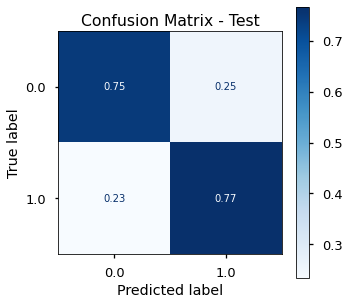

In [39]:
model_evaluation_f1(best_RF_insurance.best_estimator_)

### Summary of model evaluation:

* Since the cross validated, train and test scores are all close to one another, the model is not overfitting. 
* An f1 score of 80% is considered **GOOD**, having about 20% of false positives and false negatives. 
* The precision is low for the class 0, meaning out of all 0 **predictions** only **30%** were actually 0, but this might be expected due to high number of 1's in the dataset. 

### Retrain Model on Full Dataset and Make Predictions:
Now that we have an idea of our performance, we'll want to retrain our model on the full train dataset before generating our predictions on the test set.

In [40]:
X_insurance = df_insurance_train.drop('health_insurance', axis = 1)
y_insurance = df_insurance_train['health_insurance']

In [41]:
best_RF_insurance.best_estimator_.fit(X_insurance, y_insurance);

In [42]:
# create predictions
preds = best_RF_insurance.best_estimator_.predict(df_insurance_test)
pd.DataFrame(preds).value_counts()

1.0    7819
0.0    3695
dtype: int64

In [43]:
# Add the predictions to the test features dataset
df_insurance_test['health_insurance'] = preds

In [44]:
# test data set with newly predicted values plugged in
df_insurance_test[['sex','hhs_geo_region', 'health_insurance','seasonal_vaccine']]

,sex,hhs_geo_region,health_insurance,seasonal_vaccine
2,Male,qufhixun,0.0,0
3,Female,lrircsnp,1.0,1
4,Female,qufhixun,0.0,0
5,Male,atmpeygn,1.0,0
6,Male,qufhixun,0.0,0
...,...,...,...,...
26695,Male,lrircsnp,0.0,0
26698,Female,atmpeygn,1.0,1
26700,Female,lzgpxyit,1.0,1
26702,Female,qufhixun,1.0,0


In [45]:
# The train dataset with health insurance info already available
df_insurance_train[['sex','hhs_geo_region', 'health_insurance','seasonal_vaccine']]

,sex,hhs_geo_region,health_insurance,seasonal_vaccine
0,Female,oxchjgsf,1.0,0
1,Male,bhuqouqj,1.0,1
7,Female,bhuqouqj,1.0,1
9,Male,qufhixun,1.0,0
10,Male,lzgpxyit,0.0,1
...,...,...,...,...
26699,Female,qufhixun,1.0,0
26701,Female,fpwskwrf,1.0,0
26703,Male,lzgpxyit,1.0,0
26705,Female,lrircsnp,0.0,0


### Come up with the full dataset:

In [46]:
# Combine the train and test datasets to come up with the full dataset again!

df = pd.concat([df_insurance_train, df_insurance_test], axis=0)
df = df.sort_index() 
df[['sex','hhs_geo_region', 'health_insurance','seasonal_vaccine']]

# We are back to 25946 rows.

,sex,hhs_geo_region,health_insurance,seasonal_vaccine
0,Female,oxchjgsf,1.0,0
1,Male,bhuqouqj,1.0,1
2,Male,qufhixun,0.0,0
3,Female,lrircsnp,1.0,1
4,Female,qufhixun,0.0,0
...,...,...,...,...
26702,Female,qufhixun,1.0,0
26703,Male,lzgpxyit,1.0,0
26704,Female,lzgpxyit,1.0,1
26705,Female,lrircsnp,0.0,0


In [47]:
data_clean[['sex','hhs_geo_region', 'health_insurance','seasonal_vaccine']]
# Making sure null replacement did not alter other data:

,sex,hhs_geo_region,health_insurance,seasonal_vaccine
0,Female,oxchjgsf,1.0,0
1,Male,bhuqouqj,1.0,1
2,Male,qufhixun,NaN,0
3,Female,lrircsnp,NaN,1
4,Female,qufhixun,NaN,0
...,...,...,...,...
26702,Female,qufhixun,NaN,0
26703,Male,lzgpxyit,1.0,0
26704,Female,lzgpxyit,NaN,1
26705,Female,lrircsnp,0.0,0


In [48]:
# Making sure the shape is the same as the original data
assert (data_clean.shape == df.shape)

### Null replacement for `income_poverty` using predictive modeling:

In [49]:
df = df.copy()

# Create a new subset of the dataframe with null values dropped. 
df_income_train = df.dropna(subset = ['income_poverty'], axis=0)

# Create a new subset of the dataframe with only null values. 
# We will use our model to predict the null values in this dataset. 
df_income_test = df[df['income_poverty'].isnull()].drop('income_poverty', axis=1)

# To be used for predicting income_poverty:
binary_columns = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 
                  'behavioral_wash_hands','behavioral_large_gatherings', 'behavioral_outside_home',
                  'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 
                  'child_under_6_months', 'health_worker', 'seasonal_vaccine', 'health_insurance']

num_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                'opinion_seas_sick_from_vacc','household_adults','household_children']

cat_columns = ['age_group', 'education', 'race', 'sex','marital_status', 
               'rent_or_own', 'employment_status','hhs_geo_region', 'census_msa']

# Specift X and y
X = df_income_train.drop('income_poverty', axis=1)
y = df_income_train['income_poverty']

# Test train split data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42)

X_train_binary = X_train[binary_columns]
X_train_nums = X_train[num_columns]
X_train_cats = X_train[cat_columns]

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('binary_preprocess', binary_preprocessing, X_train_binary.columns),
    ('num_preprocess', numerical_preprocessing, X_train_nums.columns),
    ('cat_preprocess', categorical_preprocessing, X_train_cats.columns)] # remainder='passthrough'
)

baseline_RF_income = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", RandomForestClassifier(random_state=42, class_weight = "balanced"))
])

# Parameter tuning:
parameters = {
    'estimator__n_estimators': [150],                      # default=100 Number of trees.
    'estimator__criterion': ['entropy', 'gini'],           # default = gini
    'estimator__max_depth': [6, 7],                  # default = None, Lower depth prevents overfitting
    'estimator__max_features': [None, 5],          # default = None (n_features), Lower values prevent overfitting  
    'estimator__min_samples_split': [5, 10, 20],  # default = 2, Higher values prevent overfitting 
    'estimator__min_samples_leaf': [2, 4, 6]            # default = 1, Higher values prevent overfitting 
}     

# Best model using GridSearchCV
best_RF_income = GridSearchCV(estimator = baseline_RF_income,    # model
                          param_grid = parameters,               # hyperparameters
                          scoring ='f1_weighted',                # metric for scoring
                          cv = 5,                                # number of folds for cross-validation
                          n_jobs = -1                            # 1 job per core of the computer.
)                      

# Train the pipeline (tranformations & predictor)
best_RF_income.fit(X_train, y_train);


In [50]:
best_RF_income.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': 7,
 'estimator__max_features': None,
 'estimator__min_samples_leaf': 4,
 'estimator__min_samples_split': 5,
 'estimator__n_estimators': 150}



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
                           precision    recall  f1-score   support

<= $75,000, Above Poverty      0.776     0.498     0.607      3195
                > $75,000      0.575     0.794     0.667      1702
            Below Poverty      0.411     0.712     0.521       674

                 accuracy                          0.614      5571
                macro avg      0.587     0.668     0.598      5571
             weighted avg      0.671     0.614     0.615      5571

--------------------------------------------------------
--------------------------------------------------------


Mean Cross Validated f1 Score: 61.59%
Train f1 Score: 63.80%
Test f1 Score: 61.47%


--------------------------------------------------------
--------------------------------------------------------




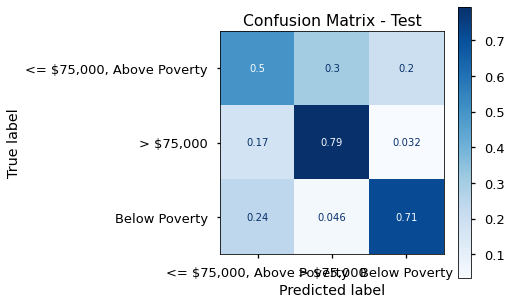

In [51]:
model_evaluation_f1(best_RF_income.best_estimator_)

### Summary of model evaluation:

* Since the cross validated, train and test scores are all close to one another, the model is not overfitting. 
* However the model is the worst for predicting those people with an income of **<75K**. 
* An overall f1 score of **61%** is considered **OK**, having about **39%** of false positives and false negatives. 
* Since this model has 3 different predictions, it is harder to reach higher accuracy levels. 
* Given the chance level is 30% this model still predicts better than chance at a level of 61%. 

### Retrain on the full train dataset and make Predictions:

In [52]:
X_income = df_income_train.drop('income_poverty', axis = 1)
y_income = df_income_train['income_poverty']

best_RF_income.best_estimator_.fit(X_income, y_income);

In [53]:
# create predictions
preds = best_RF_income.best_estimator_.predict(df_income_test)

# Add the predictions to the test features dataset
df_income_test['income_poverty'] = preds

# test data set with newly predicted values plugged in
df_income_test[['sex','hhs_geo_region', 'income_poverty','seasonal_vaccine']]

,sex,hhs_geo_region,income_poverty,seasonal_vaccine
24,Male,oxchjgsf,"> $75,000",0
26,Female,mlyzmhmf,"> $75,000",1
31,Female,mlyzmhmf,Below Poverty,0
38,Male,bhuqouqj,"> $75,000",1
39,Female,qufhixun,Below Poverty,1
...,...,...,...,...
26665,Female,oxchjgsf,Below Poverty,0
26667,Male,dqpwygqj,Below Poverty,0
26675,Male,kbazzjca,"> $75,000",1
26696,Male,bhuqouqj,"> $75,000",1


In [54]:
# The train dataset with income_poverty info already available
df_income_train[['sex','hhs_geo_region', 'income_poverty','seasonal_vaccine']]

,sex,hhs_geo_region,income_poverty,seasonal_vaccine
0,Female,oxchjgsf,Below Poverty,0
1,Male,bhuqouqj,Below Poverty,1
2,Male,qufhixun,"<= $75,000, Above Poverty",0
3,Female,lrircsnp,Below Poverty,1
4,Female,qufhixun,"<= $75,000, Above Poverty",0
...,...,...,...,...
26701,Female,fpwskwrf,"> $75,000",0
26702,Female,qufhixun,"<= $75,000, Above Poverty",0
26703,Male,lzgpxyit,"<= $75,000, Above Poverty",0
26705,Female,lrircsnp,"<= $75,000, Above Poverty",0


In [55]:
# Combine the train and test datasets to come up with the full dataset again!

df = pd.concat([df_income_train, df_income_test], axis=0)
df = df.sort_index() 
df[['sex','hhs_geo_region', 'income_poverty','seasonal_vaccine']]

# We are back to 25946 rows.

,sex,hhs_geo_region,income_poverty,seasonal_vaccine
0,Female,oxchjgsf,Below Poverty,0
1,Male,bhuqouqj,Below Poverty,1
2,Male,qufhixun,"<= $75,000, Above Poverty",0
3,Female,lrircsnp,Below Poverty,1
4,Female,qufhixun,"<= $75,000, Above Poverty",0
...,...,...,...,...
26702,Female,qufhixun,"<= $75,000, Above Poverty",0
26703,Male,lzgpxyit,"<= $75,000, Above Poverty",0
26704,Female,lzgpxyit,"<= $75,000, Above Poverty",1
26705,Female,lrircsnp,"<= $75,000, Above Poverty",0


In [56]:
# Making sure the shape is the same as the original data
assert (data_clean.shape == df.shape)

### Final data set to be used for classifications is "df":

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25946 entries, 0 to 26706
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   behavioral_antiviral_meds    25879 non-null  float64
 1   behavioral_avoidance         25750 non-null  float64
 2   behavioral_face_mask         25929 non-null  float64
 3   behavioral_wash_hands        25911 non-null  float64
 4   behavioral_large_gatherings  25866 non-null  float64
 5   behavioral_outside_home      25867 non-null  float64
 6   behavioral_touch_face        25826 non-null  float64
 7   doctor_recc_seasonal         23972 non-null  float64
 8   chronic_med_condition        25701 non-null  float64
 9   child_under_6_months         25882 non-null  float64
 10  health_worker                25890 non-null  float64
 11  health_insurance             25946 non-null  float64
 12  opinion_seas_vacc_effective  25902 non-null  float64
 13  opinion_seas_ris

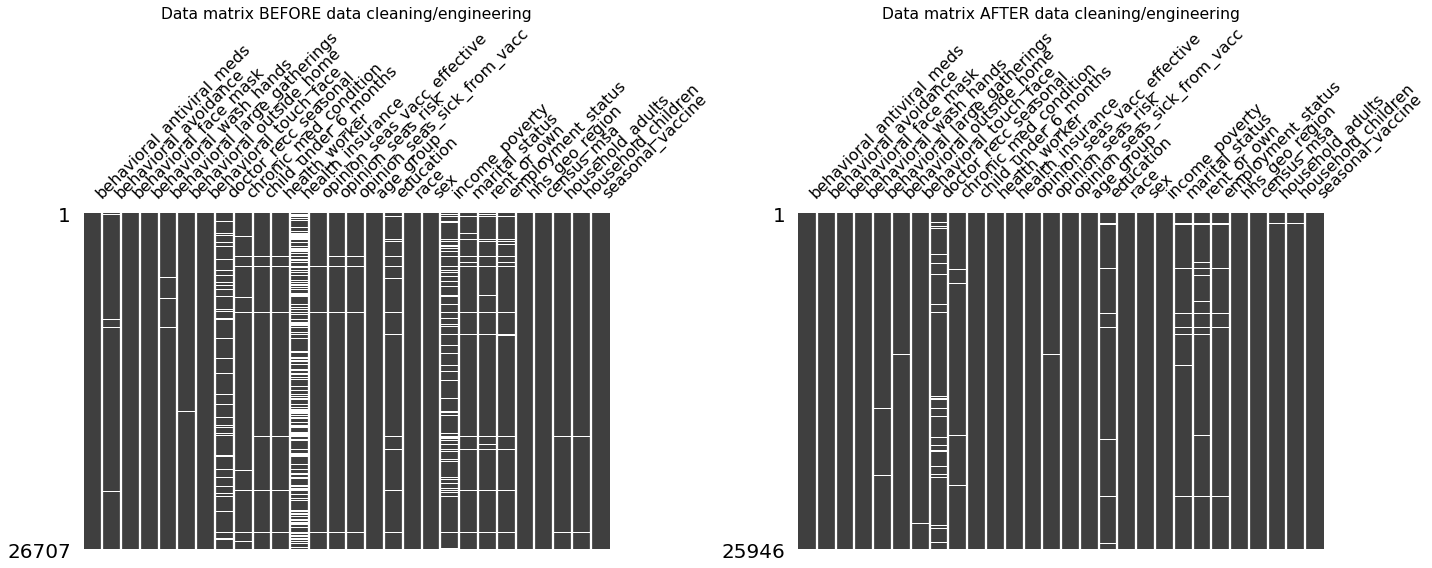

In [58]:
# Compare the original dataset with the preprocessed dataset in terms of null values:
# The final data set that would be used for predicting vaccine status is df:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols =2, figsize=(20, 8))
    missingno.matrix(data,  ax=ax1) 
    ax1.set_title('Data matrix BEFORE data cleaning/engineering')
    missingno.matrix(df, ax=ax2)
    ax2.set_title('Data matrix AFTER data cleaning/engineering');
    plt.tight_layout()
    plt.savefig('./images/DataMatrix_BeforeAfterCleaning.png', dpi=300, bbox_inches='tight')

# PREDICTING `SEASONAL VACCINE`:


### `roc_auc` as the scoring metric :

* Roc_Auc will be used as the scoring metric for tuning hyperparameters and comparing among different models and techniques. 
* We care equally about positive and negative classes.
* The Roc_Auc metric utilizes **"probabilities"** of class prediction. Based on that, we’re able to more precisely evaluate and compare the models.
* ROC curve for the final model allows us to choose a **threshold** that gives a desirable balance between **sensitivity/recall (maximizing True positive Rate)** and **specificity (minimizing False Positives)**. 
* Computing Roc_Auc on train set, will tell if model is confident in it’s learning or not. 
* Computing Roc_Auc on test set will tell, how good it performed on unknown dataset - generalizability. 
* Our focus is not just good predictions, but we want to delve deeper and understand feature importance and model characteristics. Because of this we will check out metrics on both train and test sets.
* I will be using train, validation and test sets, where I will use hyper parameter tuning on the train with cross validation on validation sets, Roc_Auc based model selection and final evaluation based on test set.


### Define X and y:

In [59]:
X = df.drop('seasonal_vaccine', axis=1)
y = df['seasonal_vaccine']

### Test and Train Split:

In [60]:
# Features to be used for predicting main target seasonal_vaccine:
binary_columns = ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 
                  'behavioral_wash_hands','behavioral_large_gatherings', 'behavioral_outside_home',
                  'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 
                  'child_under_6_months', 'health_worker', 'health_insurance']

num_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                'opinion_seas_sick_from_vacc','household_adults','household_children']

cat_columns = ['age_group', 'education', 'race', 'sex','income_poverty', 'marital_status', 
               'rent_or_own', 'employment_status','hhs_geo_region', 'census_msa']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42)

X_train_binary = X_train[binary_columns]
X_train_nums = X_train[num_columns]
X_train_cats = X_train[cat_columns]

# MODEL #1 Logistic Regression:

## Preprocessing Steps:
- **NA imputation** for both ordinal/numerical and categorical variables
    * For the ordinal variables, let's impute with the median.
    * For the categorical variables, let's impute with the most frequent. 
- **One-Hot-Encoding** for the categorical variables
- **Scaling** for the ordinal/numerical variables

### "Preprocessing" pipeline for the numerical/ordinal and categorical/nominal columns:

In [62]:
binary_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='most_frequent'))
])

numerical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_preprocessing = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

#grab columns out of a pandas data frame and then apply a specified transformer.
preprocessor = ColumnTransformer(transformers=[
    ('binary_preprocess', binary_preprocessing, X_train_binary.columns),
    ('num_preprocess', numerical_preprocessing, X_train_nums.columns),
    ('cat_preprocess', categorical_preprocessing, X_train_cats.columns)] # remainder='passthrough'
)

### Model pipeline:

In [63]:
baseline_logreg = Pipeline([
    ("preprocessor", preprocessor),
    ("estimator", LogisticRegression(random_state=42)) # use random state so that your model results are reproducable. 
])

# Train model
baseline_logreg.fit(X_train, y_train);


In [64]:
# The data frame after preprocessing:
cat_feature_names = preprocessor.named_transformers_['cat_preprocess'].named_steps['ohe'].get_feature_names(X_train_cats.columns)
feature_names = np.r_[X_train_binary.columns, X_train_nums.columns, cat_feature_names]

X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns= feature_names)
X_train_transformed

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19454,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19456,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19457,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# The test data frame after preprocessing:
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), columns= feature_names)
X_test_transformed

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Principle City",census_msa_Non-MSA
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6482,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6483,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6484,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [66]:
def baseline_model_evaluation(model):

    with plt.style.context('seaborn-talk'):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

        # Plot confusion matrix for the train set
        plot_confusion_matrix(model, X_train, y_train, normalize = 'true', ax=ax1,  cmap = 'Blues') 
        ax1.grid(False) 
        ax1.set_title("Confusion Matrix - Train")
        
        # plot Roc curve for the train
        plot_roc_curve(model, X_train, y_train, ax=ax2, name ='Train ROC curve')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Receiver operating characteristic (ROC) Curve')
        plt.show()
        
        # Find Roc_Auc Scores:

        score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train, 
                         cv=StratifiedKFold(shuffle=True, random_state = 42), scoring='roc_auc').mean()
        score_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
        
        # Find Accuracy Scores:
        acc_score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train, 
                                             cv=StratifiedKFold(shuffle=True), scoring='accuracy').mean()
        acc_score_train = accuracy_score(y_train, model.predict(X_train)) 
        
        
        divider = ('----' * 13) 
        print('\n', divider, divider, '\n' , sep='\n')
        print(f" Mean Cross Validated Roc_Auc Score: {score_train_cv :.2%}")    
        print(f" Train Roc_Auc Score: {score_train :.2%}") 
        print('\n', divider, divider, '\n' , sep='\n')

        print(f" Mean Cross Validated Accuracy Score: {acc_score_train_cv :.2%}")    
        print(f" Train Accuracy Score: {acc_score_train :.2%}")  
        print('\n', divider, divider, '\n' , sep='\n')
        

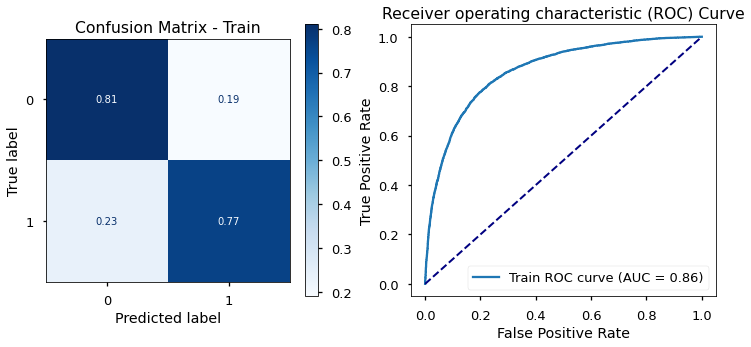



----------------------------------------------------
----------------------------------------------------


 Mean Cross Validated Roc_Auc Score: 86.18%
 Train Roc_Auc Score: 86.38%


----------------------------------------------------
----------------------------------------------------


 Mean Cross Validated Accuracy Score: 78.85%
 Train Accuracy Score: 78.95%


----------------------------------------------------
----------------------------------------------------




In [67]:
baseline_model_evaluation(baseline_logreg);

### Parameter Tuning with GridSearchCV

#### Hyperparameters for logistic regression:

* **penalty** — Specify the norm of the penalty.
* **fit_intercept** - Specify whether to use an interceot term or not. 
* **C** — Inverse of regularization strength; smaller values specify stronger regularization.
* **solver** — Algorithm to use in the optimization problem.
* **max_iter** — Maximum number of iterations taken for the solvers to converge.

In [68]:
# There should be two underscores between estimator name and it's parameters in a Pipeline

parameters = {
    'estimator__penalty' : ['l1','l2'], # default = l2 elasticnet is both
    'estimator__fit_intercept':[True, False],
    'estimator__C'       : [0.001,0.01,0.1,0.5,1,10,100], #np.logspace(-3,3,7) # default=1.0
    'estimator__solver'  : ['newton-cg', 'lbfgs', 'liblinear'], # default = ’lbfgs’
    'estimator__max_iter'  : [50,100,200,300]  # default = 100
}
      
# Create the grid, with "logreg_pipeline" as the estimator
best_logreg = GridSearchCV(estimator = baseline_logreg,   # model
                          param_grid = parameters,     # hyperparameters
                          scoring ='roc_auc',          # metric for scoring
                          cv = 5,                      # number of folds for cross-validation
                          n_jobs = -1                  # 1 job per core of the computer.
)                      

# Train the pipeline (tranformations & predictor)
best_logreg.fit(X_train, y_train);

In [69]:
best_logreg.best_params_

{'estimator__C': 0.1,
 'estimator__fit_intercept': True,
 'estimator__max_iter': 50,
 'estimator__penalty': 'l2',
 'estimator__solver': 'lbfgs'}

In [70]:
def bestfit_model_evaluation(model):
    with plt.style.context('seaborn-talk'):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

        # Plot confusion matrix for the test set
        plot_confusion_matrix(model, X_test, y_test, normalize = 'true', ax=ax1,  cmap = 'Blues') 
        ax1.grid(False) 
        ax1.set_title("Confusion Matrix - Train")
        
        # plot Roc curve for the test and train
        plot_roc_curve(model, X_train, y_train, ax=ax2, name ='Train ROC curve')
        plot_roc_curve(model, X_test, y_test, ax=ax2, name ='Test ROC curve' )
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Receiver operating characteristic (ROC) Curve')
        plt.show()
        
        # Print classification Scores for the test set
        y_true = y_test
        y_pred = model.predict(X_test)
        divider = ('----' * 14) 
        table_title = 'Classification Report - Test:'
        table = classification_report(y_true, y_pred, digits=3)
        print('\n', divider, table_title, divider, table, divider, divider, '\n' , sep='\n') 
        
        # Print roc_auc for test and train 
        roc_score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train, 
                                         cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()
        roc_score_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]) 
        roc_score_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        # Print accuracy for test and train 
        acc_score_train_cv = cross_val_score(estimator=model, X=X_train,  y=y_train, 
                                         cv=StratifiedKFold(shuffle=True), scoring='accuracy').mean()
        acc_score_train = accuracy_score(y_train, model.predict(X_train)) 
        acc_score_test = accuracy_score(y_test, model.predict(X_test))
        
        print(f" Mean Cross Validated Roc_Auc Score: {roc_score_train_cv :.2%}")    
        print(f" Train Roc_Auc Score: {roc_score_train :.2%}")  
        print(f" Test Roc_Auc Score: {roc_score_test :.2%}")    
        print('\n', divider, divider, '\n' , sep='\n')
        
        print(f" Mean Cross Validated Accuracy Score: {acc_score_train_cv :.2%}")    
        print(f" Train Accuracy Score: {acc_score_train :.2%}")  
        print(f" Test Accuracy Score: {acc_score_test :.2%}")    
        print('\n', divider, divider, '\n' , sep='\n')

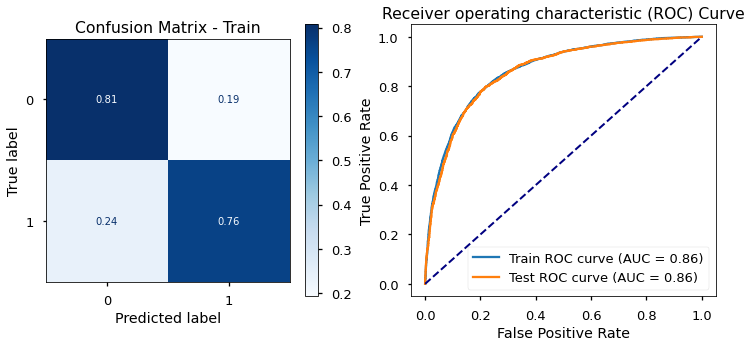



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.794     0.807     0.801      3449
           1      0.777     0.763     0.770      3038

    accuracy                          0.786      6487
   macro avg      0.786     0.785     0.785      6487
weighted avg      0.786     0.786     0.786      6487

--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Roc_Auc Score: 86.22%
 Train Roc_Auc Score: 86.38%
 Test Roc_Auc Score: 85.99%


--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Accuracy Score: 78.73%
 Train Accuracy Score: 78.94%
 Test Accuracy Score: 78.63%


--------------------------------------------------------
-----------------------------

In [71]:
bestfit_model_evaluation(best_logreg.best_estimator_)

### Summary of model evaluation:

* Since the cross validated, train and test scores are all close to one another, the model is not overfitting. 
* Both Roc_Auc and Accuracy Scores are considered **GOOD**. 

### Visualize Relative Importance of Features for Predicting Vaccine Status:

In [72]:
# estimator = name of the estimator in the pipeline
def feature_importance_logreg(model, modelname):
    coeffs = model.named_steps['estimator'].coef_ 
    importance = pd.Series(abs(coeffs[0]), index=feature_names) # logreg_coeffs[0] = getting the one-dim list inside the list
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots(figsize=(10,10))
        importance.sort_values().tail(20).plot.barh(ax=ax);        
        ax.set_title("Relative Importance of Features \n for Predicting Vaccine Status \n ({}) \n".format(modelname), fontsize=18, fontweight='bold') 
        ax.set_xlabel('Feature importance')
        ax.set_ylabel('Features')
        fig.tight_layout()
        fig.savefig('./images/{}_FeatureImportance.png'.format(modelname), dpi=300, bbox_inches='tight')
        
        

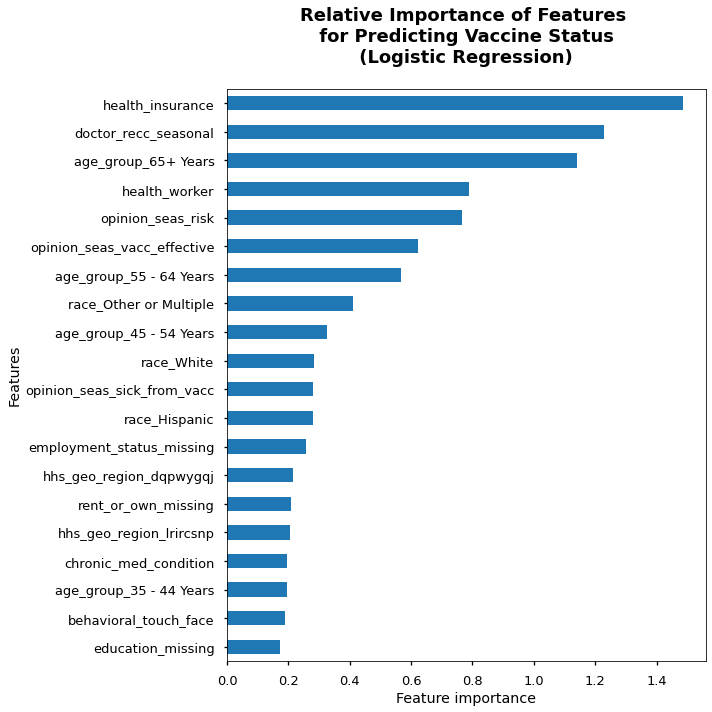

In [73]:
feature_importance_logreg(best_logreg.best_estimator_, "Logistic Regression")
#fig.savefig('./images/feature_importance_logreg.png', dpi=300);

In [74]:
## See the direction of the relationship more clearly:

coeffs = best_logreg.best_estimator_.named_steps['estimator'].coef_ 
importance = pd.Series((coeffs[0]), index=feature_names)
importance.sort_values()

opinion_seas_sick_from_vacc            -0.280998
hhs_geo_region_dqpwygqj                -0.214916
hhs_geo_region_lrircsnp                -0.205469
education_< 12 Years                   -0.159996
hhs_geo_region_bhuqouqj                -0.141035
hhs_geo_region_mlyzmhmf                -0.120602
hhs_geo_region_qufhixun                -0.112158
hhs_geo_region_lzgpxyit                -0.108725
census_msa_Non-MSA                     -0.066020
income_poverty_Below Poverty           -0.060989
hhs_geo_region_fpwskwrf                -0.058691
behavioral_outside_home                -0.050669
household_children                     -0.024495
behavioral_avoidance                   -0.018236
household_adults                       -0.009568
rent_or_own_Rent                       -0.008394
marital_status_Not Married             -0.005548
income_poverty_> $75,000                0.014975
census_msa_MSA, Principle City          0.017480
hhs_geo_region_oxchjgsf                 0.020649
behavioral_large_gat

# MODEL #2 Decision Tree:

### Baseline Model:

In [75]:
baseline_dTree = Pipeline([
    ("preprocessor", preprocessor),
    ('estimator', DecisionTreeClassifier(random_state= 42))
])

baseline_dTree.fit(X_train, y_train);

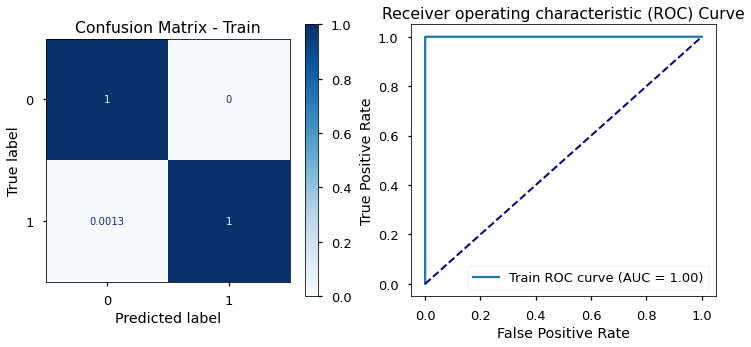



----------------------------------------------------
----------------------------------------------------


 Mean Cross Validated Roc_Auc Score: 69.40%
 Train Roc_Auc Score: 100.00%


----------------------------------------------------
----------------------------------------------------


 Mean Cross Validated Accuracy Score: 69.26%
 Train Accuracy Score: 99.94%


----------------------------------------------------
----------------------------------------------------




In [76]:
baseline_model_evaluation(baseline_dTree)

### Best Model:

### Hyperparameter Tuning:

* The baseline model is **overfitting**: the model picks up on patterns that are specific to the observations in the training data, but do not generalize to other observations. The model is able to make perfect predictions on the data it was trained on (roc_auc = 1), but is not able to make good predictions on 5-fold validation data (roc_auc = .69).

* Given the architecture of decision trees, if the model is allowed to be trained to its full strength, the model is almost always going to overfit the training data. To avoid overfitting the training data, we need to restrict the Decision Tree’s freedom during training - more regularization - adjust the hyperparameters.
  
   
#### Hyperparameters for decision trees:

* **criterion** — Specify the norm of the penalty.
* **max_depth** - The maximum depth of the tree, most important feature to avoid overfitting. If it is not specified in the Decision Tree, the nodes will be expanded until all leaf nodes are pure. The deeper you allow, the more complex our model will become and more likely to overfit. 
* **max_features** — Max_feature is the number of features to consider (randomly chosen) each time to make the split decision. It is used to control overfitting. 
* **min_samples_split** — The minimum number of samples required to split an internal node.
* **min_samples_leaf** — The minimum number of samples required to be at a leaf node. Try setting these values greater than one. This has a similar effect as max_depth, it means the branch will stop splitting once the leaves have that number of samples each.


In [77]:
# default parameters used:
baseline_dTree.named_steps['estimator'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [78]:
parameters = {
    'estimator__criterion': ['gini', 'entropy'],    # default = gini
    'estimator__max_depth': [6, 8, 10, 12],         # default = None , Lower values avoid overfitting
    'estimator__max_features': [None, 15,  5],      # default = None (n features). Lower values avoid overfitting
    'estimator__min_samples_split': [2, 100, 200],  # default = 2 , Higher values avoid overfitting
    'estimator__min_samples_leaf': [1, 4, 6, 8, 10] # default = 1 , Higher values avoid overfitting
}

best_dTree = GridSearchCV(estimator = baseline_dTree,    
                          param_grid = parameters,     
                          scoring ='roc_auc',          
                          cv = 5,
                          n_jobs = -1
)

best_dTree.fit(X_train, y_train);

In [79]:
best_dTree.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': 8,
 'estimator__max_features': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 200}

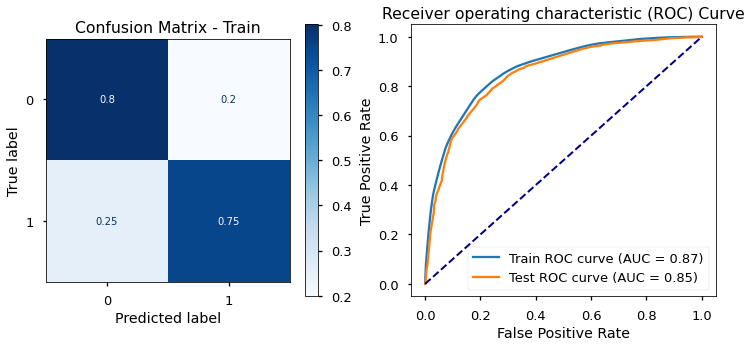



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.782     0.801     0.791      3449
           1      0.768     0.747     0.757      3038

    accuracy                          0.776      6487
   macro avg      0.775     0.774     0.774      6487
weighted avg      0.775     0.776     0.775      6487

--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Roc_Auc Score: 85.37%
 Train Roc_Auc Score: 86.67%
 Test Roc_Auc Score: 84.88%


--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Accuracy Score: 78.13%
 Train Accuracy Score: 78.95%
 Test Accuracy Score: 77.56%


--------------------------------------------------------
-----------------------------

In [80]:
bestfit_model_evaluation(best_dTree.best_estimator_)

### Summary of model evaluation:

* Since the cross validated, train and test scores are all close to one another, the model is not overfitting. 
* Both Roc_Auc and Accuracy Scores are considered **GOOD**. 
* The Decision Tree scored very close to but slighly worse than the Logistic Regression. 

# MODEL #3 Random Forest:

### Baseline Model:

In [81]:
baseline_RF = Pipeline([
    ("preprocessor", preprocessor),
    ('estimator', RandomForestClassifier(random_state=42))
])
# Train model
baseline_RF.fit(X_train, y_train);

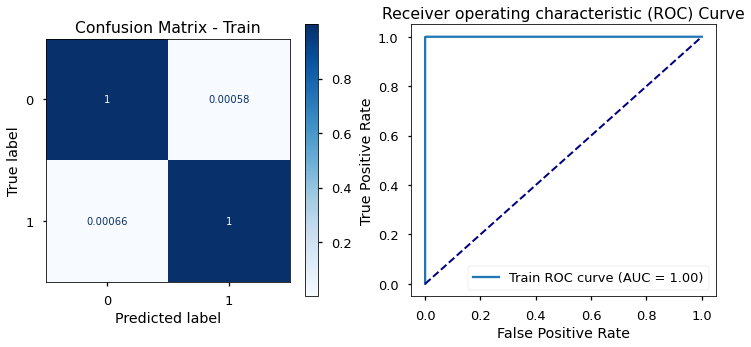



----------------------------------------------------
----------------------------------------------------


 Mean Cross Validated Roc_Auc Score: 85.48%
 Train Roc_Auc Score: 100.00%


----------------------------------------------------
----------------------------------------------------


 Mean Cross Validated Accuracy Score: 78.28%
 Train Accuracy Score: 99.94%


----------------------------------------------------
----------------------------------------------------




In [82]:
baseline_model_evaluation(baseline_RF);

### Best Model:

## Hyperparameter Tuning:

* The baseline model is **overfitting**: The model is able to make perfect predictions on the data it was trained on (roc_auc = 1), but is not able to make good predictions on the 5-fold validation data (roc_auc = .85).
   
#### Hyperparameters for Random Forests :
- Same hyperparameters as with decision tress with the addition of n_estimators. 
- `n_estimators`: The more trees, the less likely the RF algorithm is to overfit.  Try increasing this. The lower this number, the closer the model is to a decision tree, with a restricted feature set.

In [83]:
parameters = {
    'estimator__n_estimators': [150],                  # default=100 Number of trees. , Higher values prevent overfitting 
    'estimator__criterion': ['entropy', 'gini'],       # default = gini
    'estimator__max_depth': [6, 7, 8],                 # default = None, Lower depth prevents overfitting
    'estimator__max_features': [None, 5, 10, 15],      # default = None (n_features), Lower values prevent overfitting  
    'estimator__min_samples_split': [10, 20, 50, 100], # default = 2, Higher values prevent overfitting 
    'estimator__min_samples_leaf': [2, 4, 6, 8]        # default = 1, Higher values prevent overfitting 
}     
        
best_RF = GridSearchCV(estimator = baseline_RF,   
                        param_grid = parameters,     
                        scoring ='roc_auc',          
                        cv = 5,
                        n_jobs = -1)                      

best_RF.fit(X_train, y_train);

In [84]:
best_RF.best_params_

{'estimator__criterion': 'gini',
 'estimator__max_depth': 8,
 'estimator__max_features': 15,
 'estimator__min_samples_leaf': 2,
 'estimator__min_samples_split': 10,
 'estimator__n_estimators': 150}

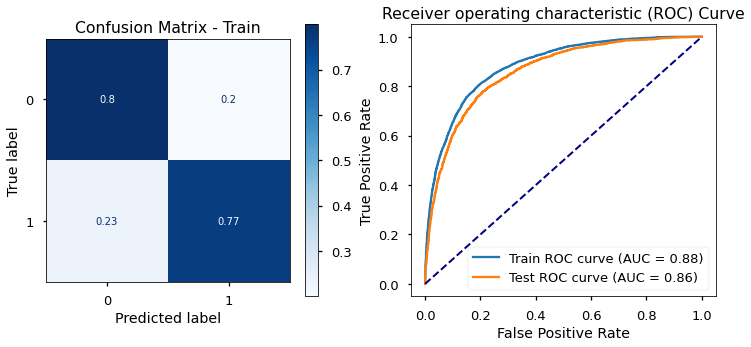



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.796     0.800     0.798      3449
           1      0.772     0.767     0.769      3038

    accuracy                          0.784      6487
   macro avg      0.784     0.783     0.784      6487
weighted avg      0.784     0.784     0.784      6487

--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Roc_Auc Score: 86.36%
 Train Roc_Auc Score: 88.34%
 Test Roc_Auc Score: 86.00%


--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Accuracy Score: 78.53%
 Train Accuracy Score: 80.48%
 Test Accuracy Score: 78.45%


--------------------------------------------------------
-----------------------------

In [85]:
bestfit_model_evaluation(best_RF.best_estimator_)

### Summary of model evaluation:

* Since the cross validated, train and test scores are all close to one another, the model is not overfitting. 
* Both Roc_Auc and Accuracy Scores are considered **GOOD**. 
* The Random Forest scored very close to but slighly better than both Logistic Regression and Decision Tree. 

# MODEL #4 XGBoost:

XGBoost is a more regularized form of Gradient Boosting. XGBoost uses advanced regularization (L1 & L2), which improves model generalization capabilities. XGBoost delivers high performance as compared to Gradient Boosting. Its training is very fast and can be parallelized across clusters.

### Baseline Model:

In [86]:
baseline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ('estimator', XGBClassifier(objective="binary:logistic", random_state=42))
])

# Train model
baseline_xgb.fit(X_train, y_train);

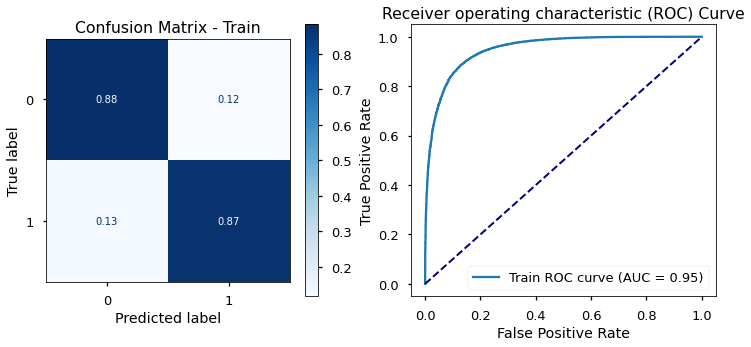



----------------------------------------------------
----------------------------------------------------


 Mean Cross Validated Roc_Auc Score: 85.40%
 Train Roc_Auc Score: 94.98%


----------------------------------------------------
----------------------------------------------------


 Mean Cross Validated Accuracy Score: 77.71%
 Train Accuracy Score: 87.77%


----------------------------------------------------
----------------------------------------------------




In [87]:
baseline_model_evaluation(baseline_xgb)

## Hyperparameter Tuning:

* The baseline model is **overfitting** again. The model is able to make close to perfect predictions on the data it was trained on (roc_auc = 96), but is not able to make good predictions when 5-fold cross validated data was used (roc_auc = .85).
   
#### Hyperparameters for XG Boost :

- `n_estimators`: Training more trees in a Random Forest reduces the likelihood of overfitting, but training more trees with GBTs **increases** the likelihood of overfitting. To avoid overfitting use **fewer trees**.
- `learning_rate`: If you reduce the learning rate in your XGBoost model, your model will also be less likely to overfit. This will act as a regularization technique that prevents your model from paying too much attention to an unimportant feature. Models that are highly complex with many parameters tend to overfit more than models that are small and simple.
- `max_depth`: The deeper you allow, the more complex our model will become and more likely to overfit.
- `gamma`: The minimum loss reduction required to make a further split; Larger values avoid over-fitting
- `min_child_weight`: The minimum number of instances needed in a node. Larger values avoid over-fitting.
- `subsample`: The ratio of the training instances used (i.e. rows used). Lower ratios avoid over-fitting.
- `colsample_bytree`: The ratio of features used (i.e. columns used). Lower ratios avoid over-fitting.

### Tuned Best Model:

In [88]:
parameters = {
    "estimator__n_estimators": [75],              # default = 100, To avoid overfitting use "fewer" trees unlike RF.
    "estimator__learning_rate": [0.05, 0.1, 0.2], # default = 0.3, Lower ratios avoid over-fitting. If you reduce the learning rate in your XGBoost model, your model will also be less likely to overfit. 
    "estimator__max_depth": [4, 5, 6],            # default = 6, It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    'estimator__gamma': [0.5, 1],                 # default = 0 , Larger values avoid over-fitting.
    'estimator__min_child_weight': [3, 4, 5],     # default = 1, Larger values avoid over-fitting. The larger min_child_weight is, the more conservative the algorithm will be. 
    'estimator__subsample': [0.5, 0.75],          # default = 1, Lower ratios avoid over-fitting.
    'estimator__colsample_bytree':[0.5, 0.75]     # default = 1, Lower ratios avoid over-fitting.
}

best_xgb = GridSearchCV(estimator = baseline_xgb,       
                        param_grid = parameters,     
                        scoring ='roc_auc',          
                        cv = 5,
                        n_jobs = -1
)                      

# Train the pipeline (tranformations & predictor)ui0
best_xgb.fit(X_train, y_train);

In [89]:
best_xgb.best_params_

{'estimator__colsample_bytree': 0.5,
 'estimator__gamma': 1,
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': 5,
 'estimator__min_child_weight': 3,
 'estimator__n_estimators': 75,
 'estimator__subsample': 0.75}

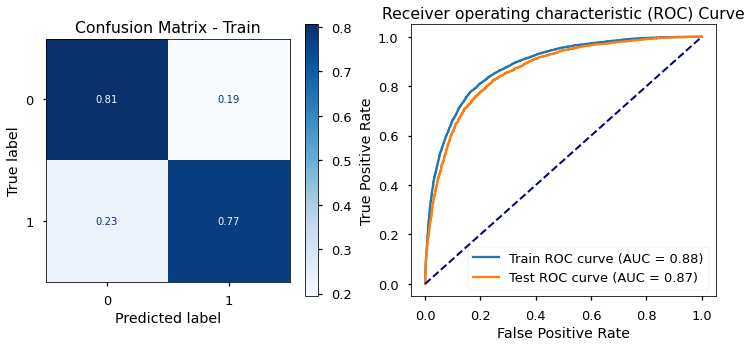



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.800     0.806     0.803      3449
           1      0.778     0.771     0.774      3038

    accuracy                          0.789      6487
   macro avg      0.789     0.788     0.788      6487
weighted avg      0.789     0.789     0.789      6487

--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Roc_Auc Score: 86.87%
 Train Roc_Auc Score: 88.46%
 Test Roc_Auc Score: 86.55%


--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Accuracy Score: 79.41%
 Train Accuracy Score: 80.69%
 Test Accuracy Score: 78.94%


--------------------------------------------------------
-----------------------------

In [90]:
bestfit_model_evaluation(best_xgb.best_estimator_)

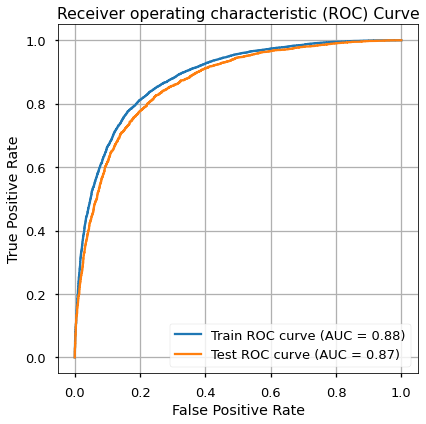

In [91]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(6, 6))

    # plot Roc curve for the test and train
    plot_roc_curve(best_xgb.best_estimator_, X_train, y_train, ax=ax, name ='Train ROC curve')
    plot_roc_curve(best_xgb.best_estimator_, X_test, y_test, ax=ax, name ='Test ROC curve' )
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic (ROC) Curve')
    ax.grid()   
    plt.tight_layout()
    plt.savefig('./images/RocCurve_XGB.png', dpi=300, bbox_inches='tight')

### Summary of model evaluation:

* Since the cross validated, train and test scores are all close to one another, the model is not overfitting. 
* Both Roc_Auc and Accuracy Scores are considered **GOOD**. 
* XGBoost Forest scored very close to but slighly better than all other models. 
* This is our best performing model. 

### Visualize feature importance:

In [92]:
# visualize feature importance from a pipeline
def feature_importance_ML(model, modelname):
    feature_importances = model.named_steps['estimator'].feature_importances_
    importance = pd.Series(feature_importances, index=feature_names) # always positive value?
    with plt.style.context('seaborn-talk'):
        fig, ax = plt.subplots(figsize=(10,10))
        importance.sort_values().tail(20).plot.barh(ax=ax);
        ax.set_title("Relative Importance of Features \n for Predicting Vaccine Status \n ({}) \n".format(modelname), fontsize=18, fontweight='bold') 
        ax.set_xlabel('Feature importance')
        ax.set_ylabel('Features')
        plt.tight_layout()
        plt.savefig('./images/{}_FeatureImportance.png'.format(modelname), dpi=300, bbox_inches='tight')
        

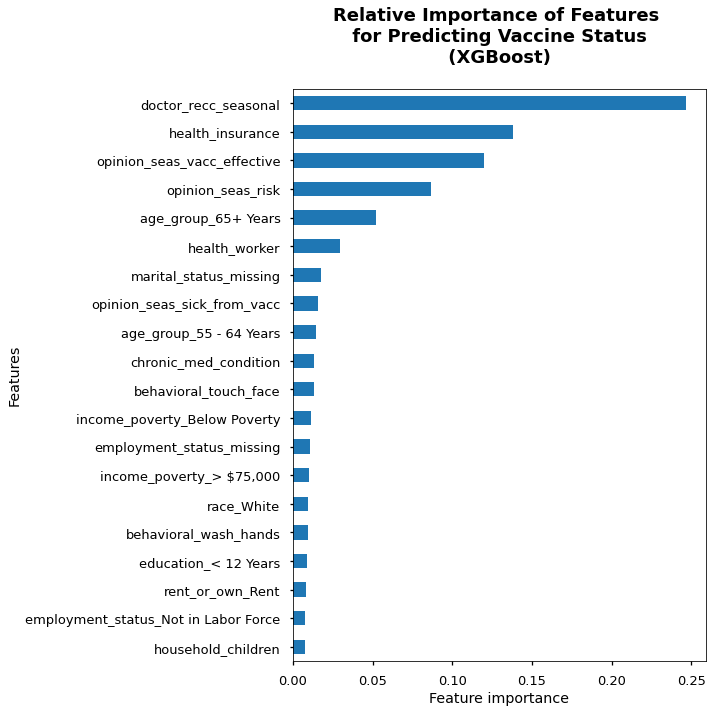

In [93]:
feature_importance_ML(best_xgb.best_estimator_, "XGBoost")

# Model #5:  Stacked Model:

In [94]:
from sklearn.ensemble import StackingClassifier

In [95]:
best_logreg.best_estimator_.named_steps['estimator'].get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 50,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [96]:
# Meta learner is Logistic Regression and the base learners are Random Forest, Logistic Regression and XGBoost 
# Stacking often considers heterogeneous weak learners, learns them in parallel, and combines them by training a meta-learner to output a prediction based on the different weak learner’s predictions. 

base_learners = [
                ('logreg', best_logreg.best_estimator_.named_steps['estimator']),
                ('RF', best_RF.best_estimator_.named_steps['estimator']),   # uses bagging (another ensemble technique)
                ('XGB', best_xgb.best_estimator_.named_steps['estimator'])  # uses boosting (another ensemble technique)
                ]

ensemble = StackingClassifier(estimators=base_learners, 
                              final_estimator = LogisticRegression(), 
                              cv=5, 
                              passthrough=False, 
                              n_jobs=-1)

stacked_model = Pipeline([
        ("preprocessor", preprocessor),
        ('ensemble',ensemble)
])

stacked_model.fit(X_train, y_train);

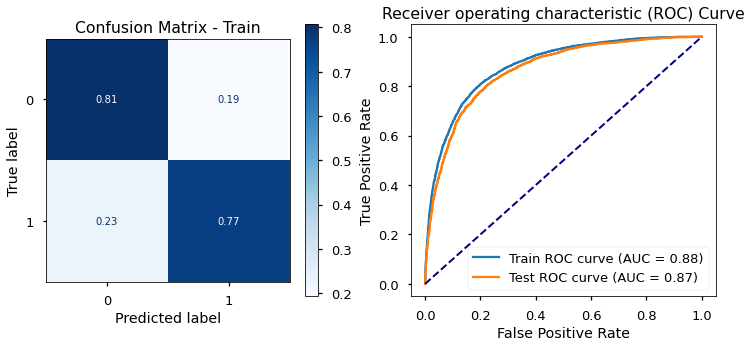



--------------------------------------------------------
Classification Report - Test:
--------------------------------------------------------
              precision    recall  f1-score   support

           0      0.799     0.807     0.803      3449
           1      0.778     0.769     0.774      3038

    accuracy                          0.789      6487
   macro avg      0.788     0.788     0.788      6487
weighted avg      0.789     0.789     0.789      6487

--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Roc_Auc Score: 86.84%
 Train Roc_Auc Score: 88.19%
 Test Roc_Auc Score: 86.54%


--------------------------------------------------------
--------------------------------------------------------


 Mean Cross Validated Accuracy Score: 79.19%
 Train Accuracy Score: 80.43%
 Test Accuracy Score: 78.91%


--------------------------------------------------------
-----------------------------

In [97]:
bestfit_model_evaluation(stacked_model)

### Summary of model evaluation:

* Since the cross validated, train and test scores are all close to one another, the model is not overfitting. 
* Both Roc_Auc and Accuracy Scores are considered **GOOD**. 
* The stacked model scored slightly worse than XGB alone, but slighly better than all other models. 

In [98]:
# stacked_model.named_steps['ensemble'].final_estimator_.coef_[0]

# Overall comparison of different ML techniques:

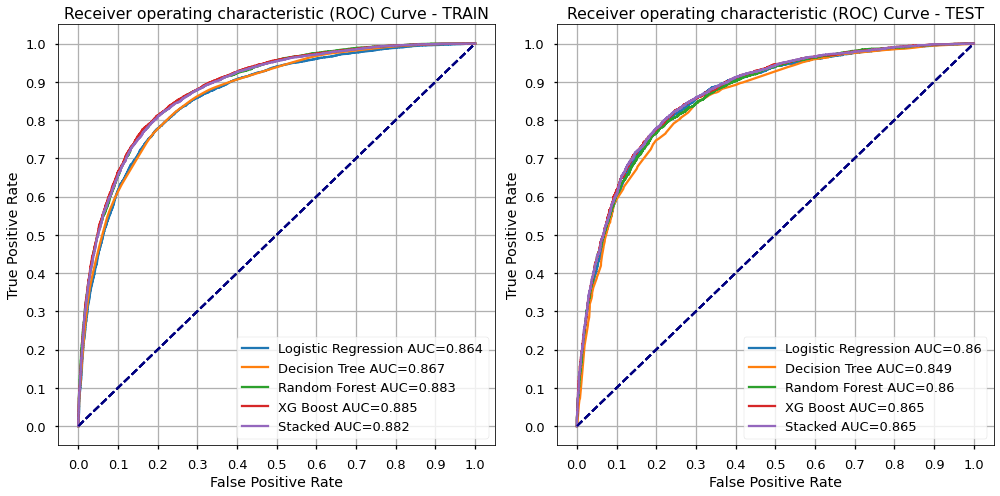

In [99]:
with plt.style.context('seaborn-talk'): #seaborn-whitegrid
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols =2, figsize=(14, 7))
    
    names = ["Logistic Regression", "Decision Tree", "Random Forest", "XG Boost", "Stacked"]
    models = [best_logreg.best_estimator_, best_dTree.best_estimator_, 
          best_RF.best_estimator_, best_xgb.best_estimator_, stacked_model]
    
    for i in range(len(names)):
        y_pred = models[i].predict_proba(X_train)[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_pred)
        auc = round(roc_auc_score(y_train, y_pred), 3)
        ax1.plot(fpr,tpr,label= names[i]+" AUC="+str(auc))
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_yticks([i/10.0 for i in range(11)])
        ax1.set_xticks([i/10.0 for i in range(11)])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('Receiver operating characteristic (ROC) Curve - TRAIN')
        ax1.legend()
        ax1.grid() 
        
    for i in range(len(names)):
        
        y_pred = models[i].predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc = round(roc_auc_score(y_test, y_pred), 3)
        ax2.plot(fpr,tpr,label= names[i]+" AUC="+str(auc))
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_yticks([i/10.0 for i in range(11)])
        ax2.set_xticks([i/10.0 for i in range(11)])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('Receiver operating characteristic (ROC) Curve - TEST')
        ax2.legend()
        ax2.grid()
        
        plt.tight_layout()
        plt.savefig('./images/Compare_RocCurve_Models', dpi=300, bbox_inches='tight')

In [100]:
def compare_roc_auc(names, models):

    cv_roc_auc_scores = []
    train_roc_auc_scores = []
    test_roc_auc_scores = []

    for i in range(len(names)):
        score_train_cv = cross_val_score(estimator=models[i], X=X_train,  y=y_train,
                                         cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()
        
        score_train = roc_auc_score(y_train, models[i].predict_proba(X_train)[:, 1]) 
        score_test = roc_auc_score(y_test, models[i].predict_proba(X_test)[:, 1])
        
        cv_roc_auc_scores.append(score_train_cv)
        train_roc_auc_scores.append(score_train)
        test_roc_auc_scores.append(score_test)
        
    scores_table = pd.DataFrame(list(zip(cv_roc_auc_scores, train_roc_auc_scores, test_roc_auc_scores)),
                             columns =['cv_train', 'train', 'test'], index = names)
    return(scores_table)


In [101]:
names = ["Logistic Regression", "Decision Tree", "Random_Forest", "XG Boost", "Stacked Model"]
models = [best_logreg.best_estimator_, best_dTree.best_estimator_, 
          best_RF.best_estimator_, best_xgb.best_estimator_, stacked_model]

compare_roc_auc(names, models)

,cv_train,train,test
Logistic Regression,0.862121,0.863755,0.859868
Decision Tree,0.852501,0.866668,0.848822
Random_Forest,0.863277,0.883372,0.859972
XG Boost,0.867373,0.884554,0.865497
Stacked Model,0.868226,0.881911,0.865410


### Summary of Model Comparisons:

* Since the train and test scores are all close to one another, none of the models are not overfitting. 
* Both Roc_Auc and Accuracy Scores are considered **GOOD** for all the models. 
* **XGBoost** is the best performing model along with the Stacked model.

### Compare Feature Importances from best 3 models:

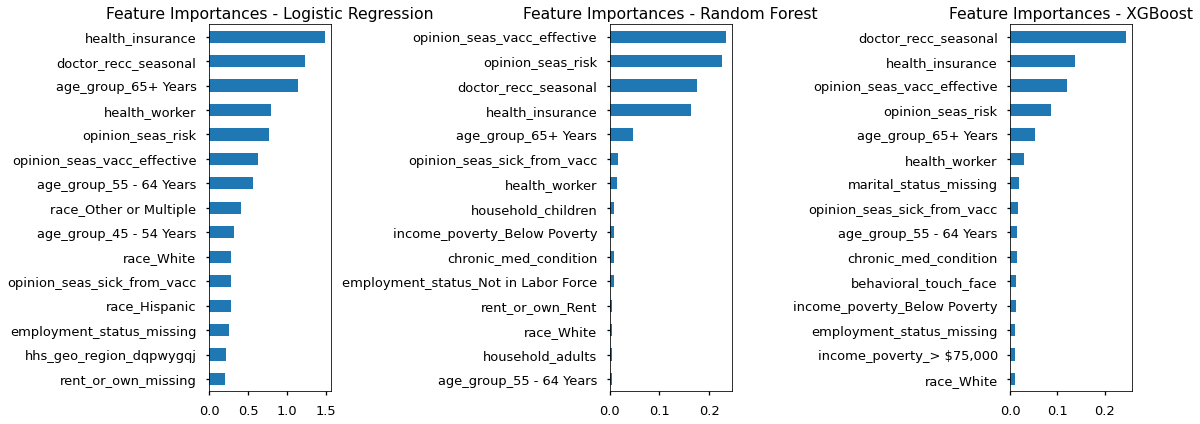

In [102]:
with plt.style.context('seaborn-talk'):

    fig, (ax1,ax2,ax3) = plt.subplots(ncols = 3, figsize=(16,6)) 
    
    coeffs = best_logreg.best_estimator_.named_steps['estimator'].coef_ 
    importance = pd.Series(abs(coeffs[0]), index=feature_names)
    importance.sort_values().tail(15).plot.barh(ax=ax1);
    ax1.set_title("Feature Importances - Logistic Regression")
    
    feature_importances = best_RF.best_estimator_.named_steps['estimator'].feature_importances_
    importance = pd.Series(feature_importances, index=feature_names)
    importance.sort_values().tail(15).plot.barh(ax=ax2);
    ax2.set_title("Feature Importances - Random Forest")
    
    feature_importances = best_xgb.best_estimator_.named_steps['estimator'].feature_importances_
    importance = pd.Series(feature_importances, index=feature_names)
    importance.sort_values().tail(15).plot.barh(ax=ax3);
    ax3.set_title("Feature Importances - XGBoost")
    
    fig.tight_layout();
    

* The most significant 6 factors are all the same across the different modeling approaches (despite differences in order)
* This makes us more confident in our results!

### Feature Importance from the Best Model - XG Boost: 

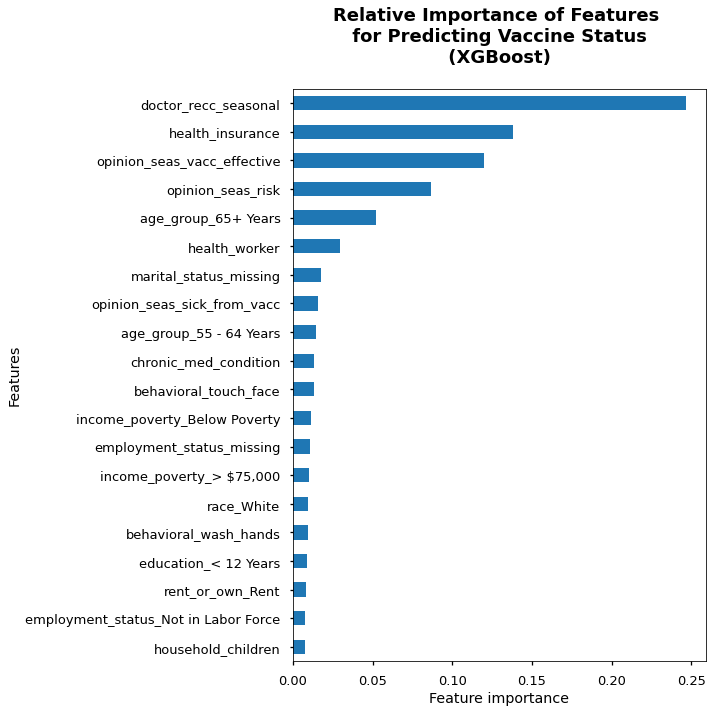

In [103]:
feature_importance_ML(best_xgb.best_estimator_, "XGBoost");

## What is the proportion of people getting the vaccine at each level of most important features?
Idea taken from:
https://drivendata.co/blog/predict-flu-vaccine-data-benchmark/

* Using the unprocessed original data for this purpose

In [104]:
# Create a Bar plot and put this in a function so that we can loop it through each variable:

def proportion_plot(column, target, ax):  # if ax = None no axis sent and default is ax = None
    
    # Counts for getting / not getting the vaccine for each class:
    counts = data[[column,target]].groupby([column, target]).size().unstack(target)
    # Getting the total numbers:
    total_counts = counts.sum(axis=1)
    # Getting the proportion of getting / not getting the vaccine for each class:
    props = counts[[0,1]].multiply(100).div(total_counts, axis=0)  
    
    props.sort_values(by = 1).plot.barh(stacked=True, color = ['tomato','royalblue'], ax = ax)
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.legend().remove()
    

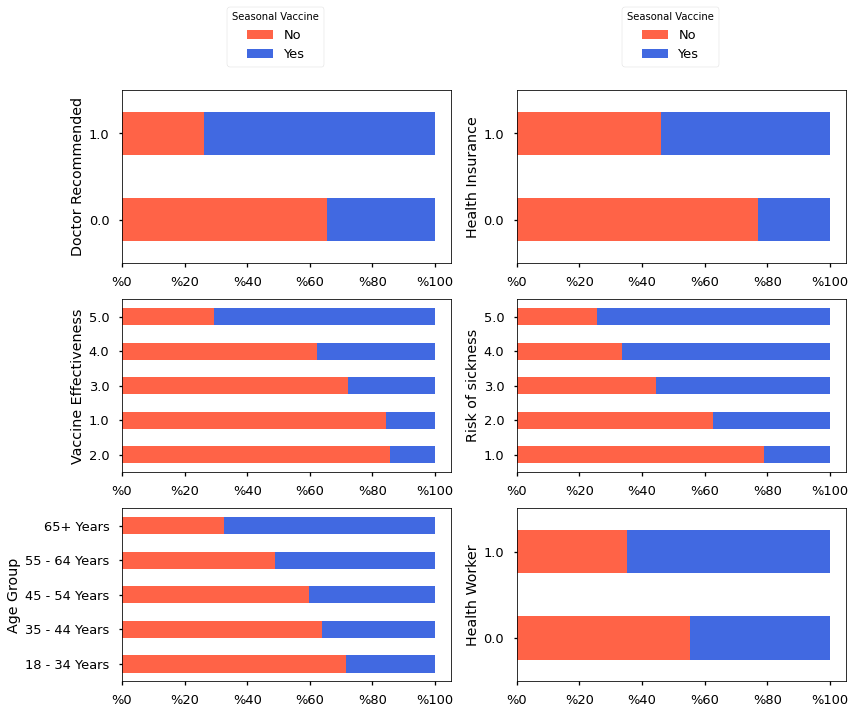

In [105]:
columns = ['doctor_recc_seasonal', 'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'age_group', 'health_worker']
labels = ["Doctor Recommended", "Health Insurance", "Vaccine Effectiveness", "Risk of sickness", "Age Group", "Health Worker"]

nrows =3
ncols =2
with plt.style.context('seaborn-talk'):
    
    fig, ax_list = plt.subplots(nrows = nrows, ncols = ncols, figsize=(12,10))  

    j=0
    for i in range(nrows):
        for u in range(ncols):
            proportion_plot(columns[j], 'seasonal_vaccine', ax = ax_list[i,u]) # need to use index for column because otherwise it does not itirate.
            ax_list[i,u].set_ylabel(labels[j])
            j = j+1

    ax_list[0, 0].legend(bbox_to_anchor=(0.3, 1.1), labels = ['No', 'Yes'], title='Seasonal Vaccine')
    ax_list[0, 1].legend(bbox_to_anchor=(0.3, 1.1), labels = ['No', 'Yes'], title='Seasonal Vaccine')

    fig.tight_layout();
    fig.savefig('./images/MostImportantFeatures_Prop_BarPlot.png', dpi=300, bbox_inches='tight')


**You are more likely to get the vaccine if:**

   - your doctor recommends the vaccine
   - you have health insurance
   - you think the vaccine is effective
   - you think you can get sick from flu
   - you are older
   - you are a health worker

### Another function to get the proportion only, so we can individualize each graph if needed:

In [106]:
def props(data, column, target): 
    counts = data[[column,target]].groupby([column, target]).size().unstack(target)
    props = counts[[0,1]].multiply(100).div(counts.sum(axis=1), axis=0)  
    return props.sort_values(by = 1)


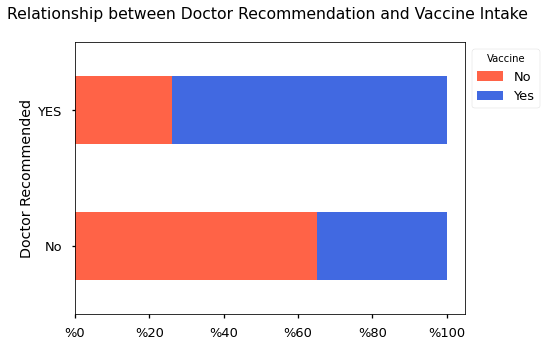

In [107]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(7, 5))
    props(df,"doctor_recc_seasonal","seasonal_vaccine").plot.barh(stacked=True, color = ['tomato','royalblue'], ax=ax)
    ax.legend(bbox_to_anchor=(1, 1), labels = ['No', 'Yes'], title='Vaccine')
    ax.set_ylabel("Doctor Recommended")
    ax.set_yticks([0,1])
    ax.set_yticklabels(["No", "YES"])
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.set_title("Relationship between Doctor Recommendation and Vaccine Intake \n")

### What about the predicted values from the model?

* How likely it is that a person with a certain feature (e.g. with a doctor who recommended the vaccine) would be getting the vaccine - when all other variables are kept constant?

* Create a new data set with **predicted probabilities** after the model was trained, and graph the most important features for predicting vaccine stats. 

In [108]:
# fit the best model to the whole dataset to make predictions:
X1 = X
y1 = y

best_xgb.best_estimator_.fit(X1,y1)

y_pred = best_xgb.best_estimator_.predict_proba(X1)[:, 1] 
# Create a new column called seasonal_vaccine_pred with the predicted probabilities. 
X1['seasonal_vaccine_pred'] = y_pred
df_predicted= X1

# New data set with the predicted probabilities added:
df_predicted.head()

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,seasonal_vaccine_pred
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0.094791
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0.151864
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,...,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0.034903
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0.927841
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0.027358


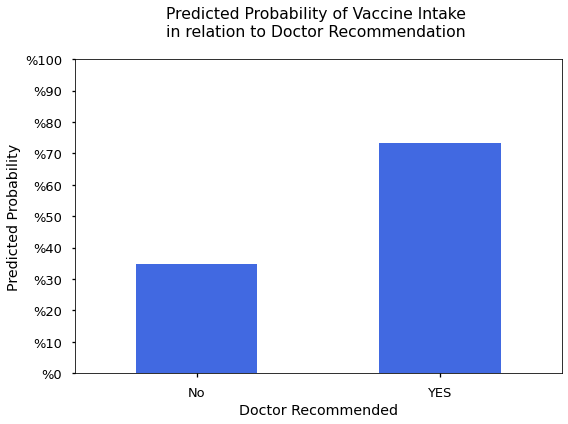

In [109]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(8, 6))
    (df_predicted.groupby("doctor_recc_seasonal")['seasonal_vaccine_pred'].mean()*100).plot.bar(ax=ax, color = 'royalblue')
    ax.set_xlabel("Doctor Recommended")
    ax.set_ylabel("Predicted Probability")
    ax.set_yticks(range(0,110,10))
    ax.set_xticks([0,1])
    ax.set_xticklabels(["No", "YES"], rotation = 0)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.set_title("Predicted Probability of Vaccine Intake \nin relation to Doctor Recommendation \n")
    #ax.grid(axis = 'y')
    fig.tight_layout()
    fig.savefig('./images/PredictedPlot_Doctor_Recc', dpi=300, bbox_inches='tight')
        

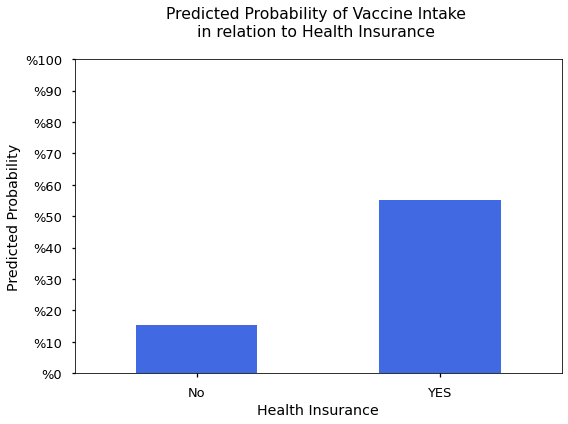

In [110]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(8, 6))
    (df_predicted.groupby("health_insurance")['seasonal_vaccine_pred'].mean()*100).plot.bar(ax=ax, color = 'royalblue')
    ax.set_xlabel("Health Insurance")
    ax.set_xticks([0,1])
    ax.set_xticklabels(["No", "YES"], rotation = 0)
    ax.set_ylabel("Predicted Probability")
    ax.set_yticks(range(0,110,10))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.set_title("Predicted Probability of Vaccine Intake \nin relation to Health Insurance \n")
    fig.tight_layout()
    fig.savefig('./images/PredictedPlot_health_insurance', dpi=300, bbox_inches='tight')
    

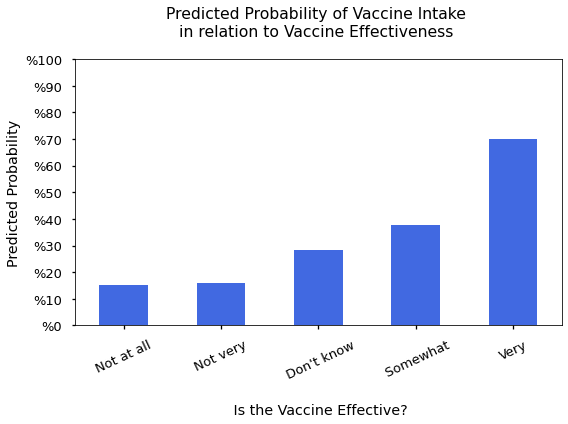

In [111]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(8, 6))
    (df_predicted.groupby("opinion_seas_vacc_effective")['seasonal_vaccine_pred'].mean()*100).plot.bar(color= 'royalblue', ax=ax)
    ax.set_xlabel("\n Is the Vaccine Effective?")
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(["Not at all", "Not very", " Don't know", " Somewhat", "Very"], rotation = 25)
    ax.set_ylabel("Predicted Probability")
    ax.set_yticks(range(0,110,10))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.set_title("Predicted Probability of Vaccine Intake \nin relation to Vaccine Effectiveness \n")
    fig.tight_layout()
    fig.savefig('./images/PredictedPlot_opinion_seas_vacc_effective', dpi=300, bbox_inches='tight')
    

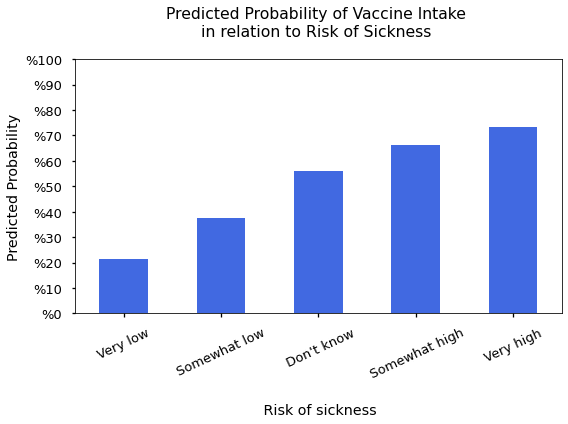

In [112]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(8, 6))
    (df_predicted.groupby("opinion_seas_risk")['seasonal_vaccine_pred'].mean()*100).plot.bar(ax=ax, color = 'royalblue')
    ax.set_xlabel("\n Risk of sickness")
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(["Very low", "Somewhat low", " Don't know", " Somewhat high", "Very high"], rotation = 25)
    ax.set_ylabel("Predicted Probability")
    ax.set_yticks(range(0,110,10))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.set_title("Predicted Probability of Vaccine Intake \nin relation to Risk of Sickness \n")
    fig.tight_layout()
    fig.savefig('./images/PredictedPlot_opinion_seas_risk', dpi=300, bbox_inches='tight')
    

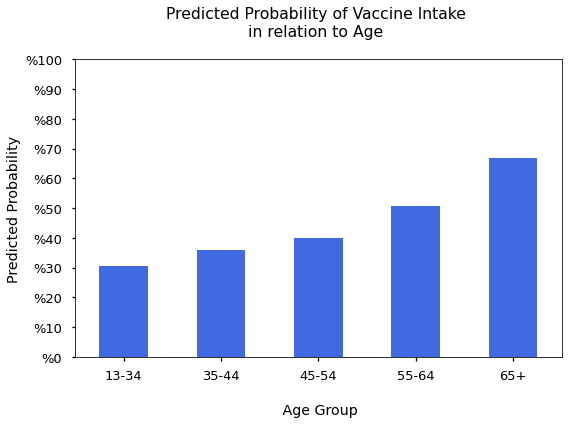

In [113]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(8,6))
    (df_predicted.groupby("age_group")['seasonal_vaccine_pred'].mean()*100).plot.bar(ax=ax, color = 'royalblue')
    ax.set_xlabel("\n Age Group")
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(["13-34", "35-44", "45-54", "55-64", "65+"], rotation = 0)
    ax.set_ylabel("Predicted Probability")
    ax.set_yticks(range(0,110,10))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.set_title("Predicted Probability of Vaccine Intake \nin relation to Age \n")
    fig.tight_layout()
    fig.savefig('./images/PredictedPlot_age_group', dpi=300, bbox_inches='tight')
    

### Other Key Demographics:

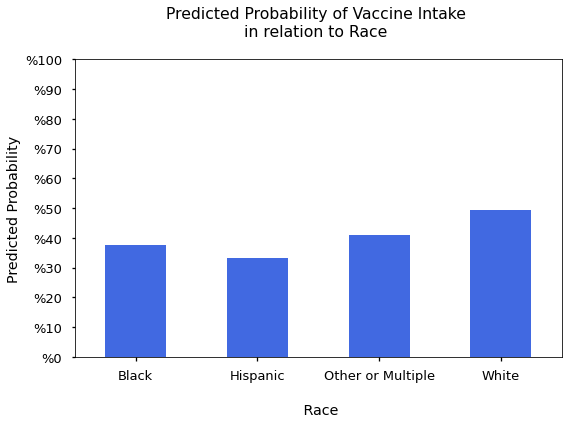

In [114]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(8,6))
    (df_predicted.groupby("race")['seasonal_vaccine_pred'].mean()*100).plot.bar(ax=ax, color = 'royalblue')
    ax.set_xlabel("\n Race")
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["Black", "Hispanic", "Other or Multiple", "White"], rotation = 0)
    ax.set_ylabel("Predicted Probability")
    ax.set_yticks(range(0,110,10))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.set_title("Predicted Probability of Vaccine Intake \nin relation to Race \n")
    fig.tight_layout()
    fig.savefig('./images/PredictedPlot_race', dpi=300, bbox_inches='tight')

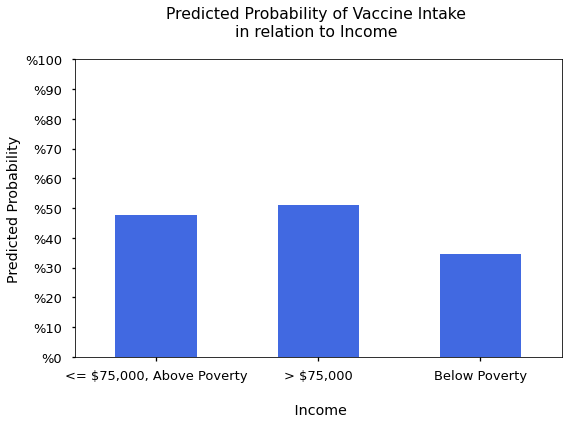

In [115]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(figsize=(8,6))
    (df_predicted.groupby("income_poverty")['seasonal_vaccine_pred'].mean()*100).plot.bar(ax=ax, color = 'royalblue')
    ax.set_xlabel("\n Income")
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["<= $75,000, Above Poverty", "> $75,000", "Below Poverty"], rotation = 0)
    ax.set_ylabel("Predicted Probability")
    ax.set_yticks(range(0,110,10))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) 
    ax.set_title("Predicted Probability of Vaccine Intake \nin relation to Income \n")
    fig.tight_layout()
    fig.savefig('./images/PredictedPlot_income', dpi=300, bbox_inches='tight')



## Recommendations

* Target physicians by educating them on the importance of vaccination &  recommending it to their patients!
* Target uninsured populations in the campaign, but better yet work on universal health coverage for all individuals and communities.
* Focus your campaign on informing the people about the effectiveness and safety of the vaccine or their risk of falling ill and developing complications if not vaccinated. 
* As a priority keep focusing your campaign on older age groups, because they are at more risk of developing flu-related complications compared to younger age groups.But also target younger people as a key demographic population to maximize the benefits of herd immunity since their vaccination rates are much lower.


## Next Steps

* Encrypted employment industry, employment occupation, and geographical region info, hard to make any specific suggestions based on these features. 
* Results on health insurance are not very reliable due to %40 of the data being null and being encoded using predictive modeling. More care needs to be given to this variable next time the survey is conducted. 
* More recent data needs to be collected after the Covid-19 pandemic since the pandemic might have altered people’s attitude towards flu vaccine as well. 

**Exporting to PDF using nbconvert**:
1. install nbconvert: ! pip install nbconvert
2. install MacTeX from tps://tug.org/mactex/
3. ! export PATH=/Library/TeX/texbin:$PATH
4. ! jupyter nbconvert --to PDF NOTEBOOKNAME.ipynb